In [ ]:
dfbase=pd.read_csv("dataset_base.csv")
dfbase

In [ ]:
dfbasefeatures=pd.read_csv("dataset_base_features.csv")
dfbasefeatures

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
import xgboost as xgb
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import warnings
import os

warnings.filterwarnings("ignore")

# 1. Cargar dataset
df = pd.read_csv("dataset_base.csv")
df['periodo'] = pd.to_datetime(df['periodo'])
df = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 2. Listado de productos
productos = df['product_id'].unique()

# 3. Salida
resultados = []
log = []

# 4. Directorios temporales
os.makedirs("autogluon_temp_ts", exist_ok=True)

for prod in tqdm(productos, desc="Procesando productos"):
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()

    datos['mes'] = datos['periodo'].dt.month
    datos['year'] = datos['periodo'].dt.year

    train = datos[datos['periodo'] < '2019-12-01'].copy()
    val = datos[datos['periodo'] == '2019-12-01'].copy()

    if len(train) < 12 or val.empty:
        continue

    X_train = train[['mes']]
    y_train = train['tn']
    X_val = val[['mes']]
    y_val = val['tn']

    maes = {}
    preds = {}

    # 1. Regresion lineal
    try:
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_val)
        maes['regresion'] = mean_absolute_error(y_val, y_pred)
        preds['regresion'] = lr.predict([[2]])[0]
    except:
        maes['regresion'] = np.inf

    # 2. ARIMA
    try:
        serie = train.set_index('periodo')['tn']
        modelo_arima = ARIMA(serie, order=(1, 1, 1)).fit()
        y_pred = modelo_arima.forecast(steps=1)
        maes['arima'] = mean_absolute_error(y_val, y_pred)
        feb_pred = modelo_arima.forecast(steps=3)[-1]
        preds['arima'] = feb_pred
    except:
        maes['arima'] = np.inf

    # 3. LightGBM
    try:
        lgb_model = lgb.LGBMRegressor(
            n_estimators=834,
            learning_rate=0.06449926163783713,
            max_depth=13,
            num_leaves=197,
            min_data_in_leaf=208,
            min_child_weight=3.7932779938198546,
            subsample=0.7032151245633396,
            subsample_freq=7,
            colsample_bytree=0.9893937066314805,
            colsample_bynode=0.8148358693555268,
            reg_alpha=4.962755134948597,
            reg_lambda=3.8191748367071927,
            max_bin=512,
            min_split_gain=0.006311109685921704,
            cat_smooth=49.82693114488869,
            random_state=42,
            boosting_type='dart',
            verbosity=-1,
            linear_tree=True
        )
        lgb_model.fit(X_train, y_train)
        y_pred = lgb_model.predict(X_val)
        maes['lgbm'] = mean_absolute_error(y_val, y_pred)
        preds['lgbm'] = lgb_model.predict([[2]])[0]
    except:
        maes['lgbm'] = np.inf

    # 4. XGBoost
    try:
        xgb_model = xgb.XGBRegressor()
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_val)
        maes['xgboost'] = mean_absolute_error(y_val, y_pred)
        preds['xgboost'] = xgb_model.predict([[2]])[0]
    except:
        maes['xgboost'] = np.inf

    # 5. AutoGluon TimeSeries
    try:
        df_serie = train[['periodo', 'tn']].copy()
        df_serie['item_id'] = str(prod)
        df_serie = df_serie.rename(columns={'periodo': 'timestamp'})
        df_serie = df_serie[['item_id', 'timestamp', 'tn']]

        ts_data = TimeSeriesDataFrame.from_data_frame(
            df_serie,
            id_column='item_id',
            timestamp_column='timestamp'
        ).fill_missing_values()

        predictor = TimeSeriesPredictor(
            prediction_length=2,
            target='tn',
            freq='MS',
            eval_metric='MASE',
            path=f"autogluon_temp_ts/{prod}",
            verbosity=0
        )

        predictor.fit(
            ts_data,
            num_val_windows=2,
            time_limit=60,
            enable_ensemble=False,
            hyperparameters={
                "ETS": {},
                "AutoARIMA": {},
                "Naive": {},
            }
        )

        forecast = predictor.predict(ts_data)
        pred_feb = forecast.loc[(str(prod), pd.Timestamp("2020-02-01")), 'mean']
        maes['autogluon'] = mean_absolute_error(y_val, [forecast.loc[(str(prod), pd.Timestamp("2019-12-01")), 'mean']])
        preds['autogluon'] = pred_feb

    except:
        maes['autogluon'] = np.inf

    # Elegir el mejor modelo
    mejor_modelo = min(maes, key=maes.get)
    pred_final = preds[mejor_modelo]
    linea_log = f"Producto {prod}: mejor modelo = {mejor_modelo}, MAE dic-2019 = {maes[mejor_modelo]:.4f}"
    print(linea_log)
    log.append(linea_log)

    resultados.append({'product_id': prod, 'tn_predicho': pred_final})

# 6. Exportar
pd.DataFrame(resultados).to_csv("predicciones_febrero2020_porproducto.csv", index=False)

with open("log_modelos.txt", "w") as f:
    for linea in log:
        f.write(linea + "\n")

print("\n Prediccion final guardada en 'predicciones_febrero2020_porproducto.csv'")
print("📄 Log guardado en 'log_modelos.txt'")


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
import xgboost as xgb
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import warnings
import os

warnings.filterwarnings("ignore")

# 1. Cargar dataset
df = pd.read_csv("dataset_base_features.csv")
df['periodo'] = pd.to_datetime(df['periodo'])
df = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 2. Listado de productos
productos = df['product_id'].unique()

# 3. Salida
resultados = []
log = []

# 4. Directorios temporales
os.makedirs("autogluon_temp_ts", exist_ok=True)

for prod in tqdm(productos, desc="Procesando productos"):
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()

    datos['mes'] = datos['periodo'].dt.month
    datos['year'] = datos['periodo'].dt.year

    train = datos[datos['periodo'] < '2019-12-01'].copy()
    val = datos[datos['periodo'] == '2019-12-01'].copy()

    if len(train) < 12 or val.empty:
        continue

    X_train = train[['mes']]
    y_train = train['tn']
    X_val = val[['mes']]
    y_val = val['tn']

    maes = {}
    preds = {}

    # 1. Regresion lineal
    try:
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_val)
        maes['regresion'] = mean_absolute_error(y_val, y_pred)
        preds['regresion'] = lr.predict([[2]])[0]
    except:
        maes['regresion'] = np.inf

    # 2. ARIMA
    try:
        serie = train.set_index('periodo')['tn']
        modelo_arima = ARIMA(serie, order=(1, 1, 1)).fit()
        y_pred = modelo_arima.forecast(steps=1)
        maes['arima'] = mean_absolute_error(y_val, y_pred)
        feb_pred = modelo_arima.forecast(steps=3)[-1]
        preds['arima'] = feb_pred
    except:
        maes['arima'] = np.inf

    # 3. LightGBM
    try:
        lgb_model = lgb.LGBMRegressor(
            n_estimators=722,
            learning_rate=0.26830103566346203,
            max_depth=8,
            num_leaves=302,
            min_data_in_leaf=65,
            min_child_weight=0.2723737879682162,
            subsample=0.6693558818396728,
            subsample_freq=3,
            colsample_bytree=0.9982366151830648,
            colsample_bynode=0.6808843764592971,
            reg_alpha=1.5889509640833777,
            reg_lambda=3.277536337616617,
            max_bin=502,
            min_split_gain=0.10250744462326401,
            cat_smooth=49.797959349843936,
            random_state=42,
            boosting_type='dart',
            verbosity=-1,
            linear_tree=True
        )
        lgb_model.fit(X_train, y_train)
        y_pred = lgb_model.predict(X_val)
        maes['lgbm'] = mean_absolute_error(y_val, y_pred)
        preds['lgbm'] = lgb_model.predict([[2]])[0]
    except:
        maes['lgbm'] = np.inf

    # 4. XGBoost
    try:
        xgb_model = xgb.XGBRegressor()
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_val)
        maes['xgboost'] = mean_absolute_error(y_val, y_pred)
        preds['xgboost'] = xgb_model.predict([[2]])[0]
    except:
        maes['xgboost'] = np.inf

    # 5. AutoGluon TimeSeries
    try:
        df_serie = train[['periodo', 'tn']].copy()
        df_serie['item_id'] = str(prod)
        df_serie = df_serie.rename(columns={'periodo': 'timestamp'})
        df_serie = df_serie[['item_id', 'timestamp', 'tn']]

        ts_data = TimeSeriesDataFrame.from_data_frame(
            df_serie,
            id_column='item_id',
            timestamp_column='timestamp'
        ).fill_missing_values()

        predictor = TimeSeriesPredictor(
            prediction_length=2,
            target='tn',
            freq='MS',
            eval_metric='MASE',
            path=f"autogluon_temp_ts/{prod}",
            verbosity=0
        )

        predictor.fit(
            ts_data,
            num_val_windows=2,
            time_limit=60,
            enable_ensemble=False,
            hyperparameters={
                "ETS": {},
                "AutoARIMA": {},
                "Naive": {},
            }
        )

        forecast = predictor.predict(ts_data)
        pred_feb = forecast.loc[(str(prod), pd.Timestamp("2020-02-01")), 'mean']
        maes['autogluon'] = mean_absolute_error(y_val, [forecast.loc[(str(prod), pd.Timestamp("2019-12-01")), 'mean']])
        preds['autogluon'] = pred_feb

    except:
        maes['autogluon'] = np.inf

    # Elegir el mejor modelo
    mejor_modelo = min(maes, key=maes.get)
    pred_final = preds[mejor_modelo]
    linea_log = f"Producto {prod}: mejor modelo = {mejor_modelo}, MAE dic-2019 = {maes[mejor_modelo]:.4f}"
    print(linea_log)
    log.append(linea_log)

    resultados.append({'product_id': prod, 'tn_predicho': pred_final})

# 6. Exportar
pd.DataFrame(resultados).to_csv("predicciones_febrero2020_porproducto1.csv", index=False)

with open("log_modelos1.txt", "w") as f:
    for linea in log:
        f.write(linea + "\n")

print("\n Prediccion final guardada en 'predicciones_febrero2020_porproducto1.csv'")
print("📄 Log guardado en 'log_modelos1.txt'")


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
import xgboost as xgb
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import warnings
import os

warnings.filterwarnings("ignore")

# 1. Cargar dataset sell-in
df = pd.read_csv("sell-in.txt", sep="\t")
df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')
df = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 2. Cargar listado fijo de productos
with open("product_id_apredecir201912.TXT", "r") as f:
    productos = [int(line.strip()) for line in f if line.strip().isdigit()]

# 3. Inicializar salida
resultados = []
log = []

# 4. Crear carpeta para modelos AutoGluon
os.makedirs("autogluon_temp_ts", exist_ok=True)

# 5. Loop por producto
for prod in tqdm(productos, desc="Procesando productos"):
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()

    datos['mes'] = datos['periodo'].dt.month
    datos['year'] = datos['periodo'].dt.year

    train = datos[datos['periodo'] < '2019-12-01'].copy()
    val = datos[datos['periodo'] == '2019-12-01'].copy()

    if len(train) < 12 or val.empty:
        continue

    X_train = train[['mes']]
    y_train = train['tn']
    X_val = val[['mes']]
    y_val = val['tn']

    maes = {}
    preds = {}

    # 1. Regresion lineal
    try:
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_val)
        maes['regresion'] = mean_absolute_error(y_val, y_pred)
        preds['regresion'] = lr.predict([[2]])[0]
    except:
        maes['regresion'] = np.inf

    # 2. ARIMA
    try:
        serie = train.set_index('periodo')['tn']
        modelo_arima = ARIMA(serie, order=(1, 1, 1)).fit()
        y_pred = modelo_arima.forecast(steps=1)
        maes['arima'] = mean_absolute_error(y_val, y_pred)
        feb_pred = modelo_arima.forecast(steps=3)[-1]
        preds['arima'] = feb_pred
    except:
        maes['arima'] = np.inf

    # 3. LightGBM
    try:
        lgb_model = lgb.LGBMRegressor(
            n_estimators=834,
            learning_rate=0.06449926163783713,
            max_depth=13,
            num_leaves=197,
            min_data_in_leaf=208,
            min_child_weight=3.7932779938198546,
            subsample=0.7032151245633396,
            subsample_freq=7,
            colsample_bytree=0.9893937066314805,
            colsample_bynode=0.8148358693555268,
            reg_alpha=4.962755134948597,
            reg_lambda=3.8191748367071927,
            max_bin=512,
            min_split_gain=0.006311109685921704,
            cat_smooth=49.82693114488869,
            random_state=42,
            boosting_type='dart',
            verbosity=-1,
            linear_tree=True
        )
        lgb_model.fit(X_train, y_train)
        y_pred = lgb_model.predict(X_val)
        maes['lgbm'] = mean_absolute_error(y_val, y_pred)
        preds['lgbm'] = lgb_model.predict([[2]])[0]
    except:
        maes['lgbm'] = np.inf

    # 4. XGBoost
    try:
        xgb_model = xgb.XGBRegressor()
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_val)
        maes['xgboost'] = mean_absolute_error(y_val, y_pred)
        preds['xgboost'] = xgb_model.predict([[2]])[0]
    except:
        maes['xgboost'] = np.inf

    # 5. AutoGluon TimeSeries
    try:
        df_serie = train[['periodo', 'tn']].copy()
        df_serie['item_id'] = str(prod)
        df_serie = df_serie.rename(columns={'periodo': 'timestamp'})
        df_serie = df_serie[['item_id', 'timestamp', 'tn']]

        ts_data = TimeSeriesDataFrame.from_data_frame(
            df_serie,
            id_column='item_id',
            timestamp_column='timestamp'
        ).fill_missing_values()

        predictor = TimeSeriesPredictor(
            prediction_length=2,
            target='tn',
            freq='MS',
            eval_metric='MASE',
            path=f"autogluon_temp_ts/{prod}",
            verbosity=0
        )

        predictor.fit(
            ts_data,
            num_val_windows=2,
            time_limit=60,
            enable_ensemble=False,
            hyperparameters={
                "ETS": {}, "AutoARIMA": {}, "Naive": {}
            }
        )

        forecast = predictor.predict(ts_data)
        pred_feb = forecast.loc[(str(prod), pd.Timestamp("2020-02-01")), 'mean']
        maes['autogluon'] = mean_absolute_error(y_val, [forecast.loc[(str(prod), pd.Timestamp("2019-12-01")), 'mean']])
        preds['autogluon'] = pred_feb

    except:
        maes['autogluon'] = np.inf

    # Elegir el mejor modelo
    mejor_modelo = min(maes, key=maes.get)
    pred_final = preds[mejor_modelo]
    linea_log = f"Producto {prod}: mejor modelo = {mejor_modelo}, MAE dic-2019 = {maes[mejor_modelo]:.4f}"
    print(linea_log)
    log.append(linea_log)

    resultados.append({'product_id': prod, 'tn_predicho': pred_final})

# 6. Exportar
pd.DataFrame(resultados).to_csv("predicciones_febrero2020_porproducto2.csv", index=False)

with open("log_modelos2.txt", "w") as f:
    for linea in log:
        f.write(linea + "\n")

print("\n✅ Predicción final guardada en 'predicciones_febrero2020_porproducto2.csv'")
print("📄 Log guardado en 'log_modelos2.txt'")


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
import xgboost as xgb
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import warnings
import os

warnings.filterwarnings("ignore")

# 1. Cargar dataset
df = pd.read_csv("sell-in.txt", sep="\t")
df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')
df = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 2. Cargar listado fijo de productos
with open("product_id_apredecir201912.TXT", "r") as f:
    productos = [int(line.strip()) for line in f if line.strip().isdigit()]

# 3. Inicializar salida
resultados = []
log = []

# 4. Crear carpeta para modelos AutoGluon
os.makedirs("autogluon_temp_ts", exist_ok=True)

productos_predichos = set()

# 5. Loop por producto
for prod in tqdm(productos, desc="Procesando productos"):
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    datos['mes'] = datos['periodo'].dt.month
    datos['year'] = datos['periodo'].dt.year

    train = datos[datos['periodo'] < '2019-12-01'].copy()
    val = datos[datos['periodo'] == '2019-12-01'].copy()

    if len(train) < 12 or val.empty:
        continue

    X_train = train[['mes']]
    y_train = train['tn']
    X_val = val[['mes']]
    y_val = val['tn']

    maes = {}
    preds = {}

    # 1. Regresion lineal
    try:
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_val)
        maes['regresion'] = mean_absolute_error(y_val, y_pred)
        preds['regresion'] = lr.predict([[2]])[0]
    except:
        maes['regresion'] = np.inf

    # 2. ARIMA
    try:
        serie = train.set_index('periodo')['tn']
        modelo_arima = ARIMA(serie, order=(1, 1, 1)).fit()
        y_pred = modelo_arima.forecast(steps=1)
        maes['arima'] = mean_absolute_error(y_val, y_pred)
        feb_pred = modelo_arima.forecast(steps=3)[-1]
        preds['arima'] = feb_pred
    except:
        maes['arima'] = np.inf

    # 3. LightGBM
    try:
        lgb_model = lgb.LGBMRegressor(
            n_estimators=834,
            learning_rate=0.06449926163783713,
            max_depth=13,
            num_leaves=197,
            min_data_in_leaf=208,
            min_child_weight=3.7932779938198546,
            subsample=0.7032151245633396,
            subsample_freq=7,
            colsample_bytree=0.9893937066314805,
            colsample_bynode=0.8148358693555268,
            reg_alpha=4.962755134948597,
            reg_lambda=3.8191748367071927,
            max_bin=512,
            min_split_gain=0.006311109685921704,
            cat_smooth=49.82693114488869,
            random_state=42,
            boosting_type='dart',
            verbosity=-1,
            linear_tree=True
        )
        lgb_model.fit(X_train, y_train)
        y_pred = lgb_model.predict(X_val)
        maes['lgbm'] = mean_absolute_error(y_val, y_pred)
        preds['lgbm'] = lgb_model.predict([[2]])[0]
    except:
        maes['lgbm'] = np.inf

    # 4. XGBoost
    try:
        xgb_model = xgb.XGBRegressor()
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_val)
        maes['xgboost'] = mean_absolute_error(y_val, y_pred)
        preds['xgboost'] = xgb_model.predict([[2]])[0]
    except:
        maes['xgboost'] = np.inf

    # 5. AutoGluon TimeSeries
    try:
        df_serie = train[['periodo', 'tn']].copy()
        df_serie['item_id'] = str(prod)
        df_serie = df_serie.rename(columns={'periodo': 'timestamp'})
        df_serie = df_serie[['item_id', 'timestamp', 'tn']]

        ts_data = TimeSeriesDataFrame.from_data_frame(
            df_serie,
            id_column='item_id',
            timestamp_column='timestamp'
        ).fill_missing_values()

        predictor = TimeSeriesPredictor(
            prediction_length=2,
            target='tn',
            freq='MS',
            eval_metric='MASE',
            path=f"autogluon_temp_ts/{prod}",
            verbosity=0
        )

        predictor.fit(
            ts_data,
            num_val_windows=2,
            time_limit=60,
            enable_ensemble=False,
            hyperparameters={
                "ETS": {}, "AutoARIMA": {}, "Naive": {}
            }
        )

        forecast = predictor.predict(ts_data)
        pred_feb = forecast.loc[(str(prod), pd.Timestamp("2020-02-01")), 'mean']
        maes['autogluon'] = mean_absolute_error(y_val, [forecast.loc[(str(prod), pd.Timestamp("2019-12-01")), 'mean']])
        preds['autogluon'] = pred_feb

    except:
        maes['autogluon'] = np.inf

    # Elegir el mejor modelo
    mejor_modelo = min(maes, key=maes.get)
    pred_final = preds[mejor_modelo]

    resultados.append({'product_id': prod, 'tn_predicho': pred_final})
    productos_predichos.add(prod)
    log.append(f"Producto {prod}: mejor modelo = {mejor_modelo}, MAE dic-2019 = {maes[mejor_modelo]:.4f}")

# 6. Fallback: completar productos faltantes con promedio últimos 12 meses
productos_faltantes = set(productos) - productos_predichos
for prod in productos_faltantes:
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    ultimos_12 = datos[datos['periodo'] < '2020-01-01'].tail(12)
    if ultimos_12.empty:
        pred_fallback = 0
    else:
        pred_fallback = ultimos_12['tn'].mean()
    resultados.append({'product_id': prod, 'tn_predicho': pred_fallback})
    log.append(f"Producto {prod}: fallback promedio últimos 12 meses = {pred_fallback:.2f}")

# 7. Exportar
resultados_df = pd.DataFrame(resultados)
resultados_df = resultados_df.sort_values("product_id")
resultados_df.to_csv("predicciones_febrero2020_porproducto2.csv", index=False)

with open("log_modelos2.txt", "w") as f:
    for linea in log:
        f.write(linea + "\n")

print("\n✅ Predicción final guardada en 'predicciones_febrero2020_porproducto2.csv'")
print("📄 Log guardado en 'log_modelos2.txt'")


In [ ]:
#Blend
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
import xgboost as xgb
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import warnings
import os

warnings.filterwarnings("ignore")

# 1. Cargar dataset
df = pd.read_csv("sell-in.txt", sep="\t")
df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')
df = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 2. Cargar listado fijo de productos
with open("product_id_apredecir201912.TXT", "r") as f:
    productos = [int(line.strip()) for line in f if line.strip().isdigit()]

# 3. Inicializar salida
resultados = []
log = []

# 4. Crear carpeta para modelos AutoGluon
os.makedirs("autogluon_temp_ts", exist_ok=True)

productos_predichos = set()

# 5. Loop por producto
for prod in tqdm(productos, desc="Procesando productos"):
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    datos['mes'] = datos['periodo'].dt.month
    datos['year'] = datos['periodo'].dt.year

    train = datos[datos['periodo'] < '2019-12-01'].copy()
    val = datos[datos['periodo'] == '2019-12-01'].copy()

    if len(train) < 12 or val.empty:
        continue

    X_train = train[['mes']]
    y_train = train['tn']
    X_val = val[['mes']]
    y_val = val['tn']

    maes = {}
    preds = {}

    # 1. Regresion lineal
    try:
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_val)
        maes['regresion'] = mean_absolute_error(y_val, y_pred)
        preds['regresion'] = lr.predict([[2]])[0]
    except:
        maes['regresion'] = np.inf
        preds['regresion'] = 0

    # 2. ARIMA
    try:
        serie = train.set_index('periodo')['tn']
        modelo_arima = ARIMA(serie, order=(1, 1, 1)).fit()
        y_pred = modelo_arima.forecast(steps=1)
        maes['arima'] = mean_absolute_error(y_val, y_pred)
        feb_pred = modelo_arima.forecast(steps=3)[-1]
        preds['arima'] = feb_pred
    except:
        maes['arima'] = np.inf
        preds['arima'] = 0

    # 3. LightGBM
    try:
        lgb_model = lgb.LGBMRegressor(
            n_estimators=834,
            learning_rate=0.06449926163783713,
            max_depth=13,
            num_leaves=197,
            min_data_in_leaf=208,
            min_child_weight=3.7932779938198546,
            subsample=0.7032151245633396,
            subsample_freq=7,
            colsample_bytree=0.9893937066314805,
            colsample_bynode=0.8148358693555268,
            reg_alpha=4.962755134948597,
            reg_lambda=3.8191748367071927,
            max_bin=512,
            min_split_gain=0.006311109685921704,
            cat_smooth=49.82693114488869,
            random_state=42,
            boosting_type='dart',
            verbosity=-1,
            linear_tree=True
        )
        lgb_model.fit(X_train, y_train)
        y_pred = lgb_model.predict(X_val)
        maes['lgbm'] = mean_absolute_error(y_val, y_pred)
        preds['lgbm'] = lgb_model.predict([[2]])[0]
    except:
        maes['lgbm'] = np.inf
        preds['lgbm'] = 0

    # 4. XGBoost
    try:
        xgb_model = xgb.XGBRegressor()
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_val)
        maes['xgboost'] = mean_absolute_error(y_val, y_pred)
        preds['xgboost'] = xgb_model.predict([[2]])[0]
    except:
        maes['xgboost'] = np.inf
        preds['xgboost'] = 0

    # 5. AutoGluon TimeSeries
    try:
        df_serie = train[['periodo', 'tn']].copy()
        df_serie['item_id'] = str(prod)
        df_serie = df_serie.rename(columns={'periodo': 'timestamp'})
        df_serie = df_serie[['item_id', 'timestamp', 'tn']]

        ts_data = TimeSeriesDataFrame.from_data_frame(
            df_serie,
            id_column='item_id',
            timestamp_column='timestamp'
        ).fill_missing_values()

        predictor = TimeSeriesPredictor(
            prediction_length=2,
            target='tn',
            freq='MS',
            eval_metric='MASE',
            path=f"autogluon_temp_ts/{prod}",
            verbosity=0
        )

        predictor.fit(
            ts_data,
            num_val_windows=2,
            time_limit=120,
            enable_ensemble=False,
            hyperparameters={ "ETS": {}, "AutoARIMA": {}, "Naive": {} }
        )

        forecast = predictor.predict(ts_data)
        pred_feb = forecast.loc[(str(prod), pd.Timestamp("2020-02-01")), 'mean']
        maes['autogluon'] = mean_absolute_error(y_val, [forecast.loc[(str(prod), pd.Timestamp("2019-12-01")), 'mean']])
        preds['autogluon'] = pred_feb

    except:
        maes['autogluon'] = np.inf
        preds['autogluon'] = 0

    # Predicción final blended
    pred_final = (
        0.30 * preds['lgbm'] +
        0.25 * preds['regresion'] +
        0.25 * preds['arima'] +
        0.15 * preds['autogluon'] +
        0.10 * preds['xgboost']
    )

    productos_predichos.add(prod)
    resultados.append({'product_id': prod, 'tn_predicho': pred_final})
    linea_log = (
        f"Producto {prod}: MAEs - LGBM={maes['lgbm']:.4f}, Reg={maes['regresion']:.4f}, "
        f"ARIMA={maes['arima']:.4f}, AutoGluon={maes['autogluon']:.4f}, XGB={maes['xgboost']:.4f}"
    )
    log.append(linea_log)

# 6. Fallback: completar productos faltantes con promedio últimos 12 meses
productos_faltantes = set(productos) - productos_predichos
for prod in productos_faltantes:
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    ultimos_12 = datos[datos['periodo'] < '2020-01-01'].tail(12)
    pred_fallback = ultimos_12['tn'].mean() if not ultimos_12.empty else 0
    resultados.append({'product_id': prod, 'tn_predicho': pred_fallback})
    log.append(f"Producto {prod}: fallback promedio últimos 12 meses = {pred_fallback:.2f}")

# 7. Exportar
resultados_df = pd.DataFrame(resultados)
resultados_df = resultados_df.sort_values("product_id")
resultados_df.to_csv("predicciones_febrero2020_blended.csv", index=False)

with open("log_modelos_blended.txt", "w") as f:
    for linea in log:
        f.write(linea + "\n")

print("\n✅ Predicción final guardada en 'predicciones_febrero2020_blended.csv'")
print("📄 Log guardado en 'log_modelos_blended.txt'")


In [ ]:
#Blend 1
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
import xgboost as xgb
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import warnings
import os

warnings.filterwarnings("ignore")

# 1. Cargar dataset
df = pd.read_csv("sell-in.txt", sep="\t")
df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')
df = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 2. Cargar listado fijo de productos
with open("product_id_apredecir201912.TXT", "r") as f:
    productos = [int(line.strip()) for line in f if line.strip().isdigit()]

# 3. Inicializar salida
resultados = []
log = []

# 4. Crear carpeta para modelos AutoGluon
os.makedirs("autogluon_temp_ts", exist_ok=True)

productos_predichos = set()

# 5. Loop por producto
for prod in tqdm(productos, desc="Procesando productos"):
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    datos['mes'] = datos['periodo'].dt.month
    datos['year'] = datos['periodo'].dt.year

    train = datos[datos['periodo'] < '2019-12-01'].copy()
    val = datos[datos['periodo'] == '2019-12-01'].copy()

    if len(train) < 12 or val.empty:
        continue

    X_train = train[['mes']]
    y_train = train['tn']
    X_val = val[['mes']]
    y_val = val['tn']

    maes = {}
    preds = {}

    # 1. Regresion lineal
    try:
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_val)
        maes['regresion'] = mean_absolute_error(y_val, y_pred)
        preds['regresion'] = lr.predict([[2]])[0]
    except:
        maes['regresion'] = np.inf
        preds['regresion'] = 0

    # 2. ARIMA
    try:
        serie = train.set_index('periodo')['tn']
        modelo_arima = ARIMA(serie, order=(1, 1, 1)).fit()
        y_pred = modelo_arima.forecast(steps=1)
        maes['arima'] = mean_absolute_error(y_val, y_pred)
        feb_pred = modelo_arima.forecast(steps=3)[-1]
        preds['arima'] = feb_pred
    except:
        maes['arima'] = np.inf
        preds['arima'] = 0

    # 3. LightGBM
    try:
        lgb_model = lgb.LGBMRegressor(
            n_estimators=834,
            learning_rate=0.06449926163783713,
            max_depth=13,
            num_leaves=197,
            min_data_in_leaf=208,
            min_child_weight=3.7932779938198546,
            subsample=0.7032151245633396,
            subsample_freq=7,
            colsample_bytree=0.9893937066314805,
            colsample_bynode=0.8148358693555268,
            reg_alpha=4.962755134948597,
            reg_lambda=3.8191748367071927,
            max_bin=512,
            min_split_gain=0.006311109685921704,
            cat_smooth=49.82693114488869,
            random_state=42,
            boosting_type='dart',
            verbosity=-1,
            linear_tree=True
        )
        lgb_model.fit(X_train, y_train)
        y_pred = lgb_model.predict(X_val)
        maes['lgbm'] = mean_absolute_error(y_val, y_pred)
        preds['lgbm'] = lgb_model.predict([[2]])[0]
    except:
        maes['lgbm'] = np.inf
        preds['lgbm'] = 0

    # 4. XGBoost
    try:
        xgb_model = xgb.XGBRegressor()
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_val)
        maes['xgboost'] = mean_absolute_error(y_val, y_pred)
        preds['xgboost'] = xgb_model.predict([[2]])[0]
    except:
        maes['xgboost'] = np.inf
        preds['xgboost'] = 0

    # 5. AutoGluon TimeSeries
    try:
        df_serie = train[['periodo', 'tn']].copy()
        df_serie['item_id'] = str(prod)
        df_serie = df_serie.rename(columns={'periodo': 'timestamp'})
        df_serie = df_serie[['item_id', 'timestamp', 'tn']]

        ts_data = TimeSeriesDataFrame.from_data_frame(
            df_serie,
            id_column='item_id',
            timestamp_column='timestamp'
        ).fill_missing_values()

        predictor = TimeSeriesPredictor(
            prediction_length=2,
            target='tn',
            freq='MS',
            eval_metric='MASE',
            path=f"autogluon_temp_ts/{prod}",
            verbosity=0
        )

        predictor.fit(
            ts_data,
            num_val_windows=2,
            time_limit=120,
            enable_ensemble=False,
            hyperparameters={ "ETS": {}, "AutoARIMA": {}, "Naive": {} }
        )

        forecast = predictor.predict(ts_data)
        pred_feb = forecast.loc[(str(prod), pd.Timestamp("2020-02-01")), 'mean']
        maes['autogluon'] = mean_absolute_error(y_val, [forecast.loc[(str(prod), pd.Timestamp("2019-12-01")), 'mean']])
        preds['autogluon'] = pred_feb

    except:
        maes['autogluon'] = np.inf
        preds['autogluon'] = 0

    # Predicción final blended
    pred_final = (
        0.45 * preds['lgbm'] +
        0.25 * preds['regresion'] +
        0.05 * preds['arima'] +
        0.15 * preds['autogluon'] +
        0.10 * preds['xgboost']
    )

    productos_predichos.add(prod)
    resultados.append({'product_id': prod, 'tn_predicho': pred_final})
    linea_log = (
        f"Producto {prod}: MAEs - LGBM={maes['lgbm']:.4f}, Reg={maes['regresion']:.4f}, "
        f"ARIMA={maes['arima']:.4f}, AutoGluon={maes['autogluon']:.4f}, XGB={maes['xgboost']:.4f}"
    )
    log.append(linea_log)

# 6. Fallback: completar productos faltantes con promedio últimos 12 meses
productos_faltantes = set(productos) - productos_predichos
for prod in productos_faltantes:
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    ultimos_12 = datos[datos['periodo'] < '2020-01-01'].tail(12)
    pred_fallback = ultimos_12['tn'].mean() if not ultimos_12.empty else 0
    resultados.append({'product_id': prod, 'tn_predicho': pred_fallback})
    log.append(f"Producto {prod}: fallback promedio últimos 12 meses = {pred_fallback:.2f}")

# 7. Exportar
resultados_df = pd.DataFrame(resultados)
resultados_df = resultados_df.sort_values("product_id")
resultados_df.to_csv("predicciones_febrero2020_blended1.csv", index=False)

with open("log_modelos_blended1.txt", "w") as f:
    for linea in log:
        f.write(linea + "\n")

print("\n✅ Predicción final guardada en 'predicciones_febrero2020_blended1.csv'")
print("📄 Log guardado en 'log_modelos_blended1.txt'")


In [ ]:
#validación ampliada a septiembre, octubre y noviembre. 0.260 en el public
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
import xgboost as xgb
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings("ignore")

# 1. Cargar dataset
df = pd.read_csv("sell-in.txt", sep="\t")
df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')
df = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 2. Cargar listado fijo de productos
with open("product_id_apredecir201912.TXT", "r") as f:
    productos = [int(line.strip()) for line in f if line.strip().isdigit()]

# 3. Inicializar salida
resultados = []
log = []
maes_resumen = []

# 4. Carpeta autogluon
os.makedirs("autogluon_temp_ts", exist_ok=True)

productos_predichos = set()

# 5. Loop por producto
for prod in tqdm(productos, desc="Procesando productos"):
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    datos['mes'] = datos['periodo'].dt.month

    train = datos[datos['periodo'] < '2019-09-01'].copy()
    val = datos[datos['periodo'].isin([
        pd.Timestamp('2019-09-01'),
        pd.Timestamp('2019-10-01'),
        pd.Timestamp('2019-11-01')
    ])].copy()

    if len(train) < 12 or val.empty:
        continue

    X_train = train[['mes']]
    y_train = train['tn']
    X_val = val[['mes']]
    y_val = val['tn']

    maes = {}
    preds = {}

    # 1. Regresión lineal
    try:
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_val)
        maes['regresion'] = mean_absolute_error(y_val, y_pred)
        preds['regresion'] = lr.predict([[2]])[0]
    except:
        maes['regresion'] = np.inf

    # 2. ARIMA
    try:
        serie = train.set_index('periodo')['tn']
        modelo_arima = ARIMA(serie, order=(1, 1, 1)).fit()
        y_pred = modelo_arima.forecast(steps=3)
        maes['arima'] = mean_absolute_error(y_val.values, y_pred.values)
        feb_pred = modelo_arima.forecast(steps=5)[-1]
        preds['arima'] = feb_pred
    except:
        maes['arima'] = np.inf

    # 3. LightGBM
    try:
        lgb_model = lgb.LGBMRegressor(
            n_estimators=834,
            learning_rate=0.06449926163783713,
            max_depth=13,
            num_leaves=197,
            min_data_in_leaf=208,
            min_child_weight=3.7932779938198546,
            subsample=0.7032151245633396,
            subsample_freq=7,
            colsample_bytree=0.9893937066314805,
            colsample_bynode=0.8148358693555268,
            reg_alpha=4.962755134948597,
            reg_lambda=3.8191748367071927,
            max_bin=512,
            min_split_gain=0.006311109685921704,
            cat_smooth=49.82693114488869,
            random_state=42,
            boosting_type='dart',
            verbosity=-1,
            linear_tree=True
        )
        lgb_model.fit(X_train, y_train)
        y_pred = lgb_model.predict(X_val)
        maes['lgbm'] = mean_absolute_error(y_val, y_pred)
        preds['lgbm'] = lgb_model.predict([[2]])[0]
    except:
        maes['lgbm'] = np.inf

    # 4. XGBoost
    try:
        xgb_model = xgb.XGBRegressor(verbosity=0)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_val)
        maes['xgboost'] = mean_absolute_error(y_val, y_pred)
        preds['xgboost'] = xgb_model.predict([[2]])[0]
    except:
        maes['xgboost'] = np.inf

    # 5. AutoGluon
    try:
        df_serie = train[['periodo', 'tn']].copy()
        df_serie['item_id'] = str(prod)
        df_serie = df_serie.rename(columns={'periodo': 'timestamp'})
        df_serie = df_serie[['item_id', 'timestamp', 'tn']]

        ts_data = TimeSeriesDataFrame.from_data_frame(
            df_serie, id_column='item_id', timestamp_column='timestamp'
        ).fill_missing_values()

        predictor = TimeSeriesPredictor(
            prediction_length=5,
            target='tn',
            freq='MS',
            eval_metric='MASE',
            path=f"autogluon_temp_ts/{prod}",
            verbosity=0
        )

        predictor.fit(
            ts_data,
            num_val_windows=2,
            time_limit=60,
            enable_ensemble=False,
            hyperparameters={"ETS": {}, "AutoARIMA": {}, "Naive": {}}
        )

        forecast = predictor.predict(ts_data)
        val_preds = [forecast.loc[(str(prod), pd.Timestamp(d)), 'mean'] for d in ['2019-09-01', '2019-10-01', '2019-11-01']]
        maes['autogluon'] = mean_absolute_error(y_val, val_preds)
        preds['autogluon'] = forecast.loc[(str(prod), pd.Timestamp("2020-02-01")), 'mean']
    except:
        maes['autogluon'] = np.inf

    mejor_modelo = min(maes, key=maes.get)
    pred_final = preds[mejor_modelo]
    resultados.append({'product_id': prod, 'tn_predicho': pred_final})
    productos_predichos.add(prod)
    log.append(f"Producto {prod}: mejor modelo = {mejor_modelo}, MAE sep-nov = {maes[mejor_modelo]:.4f}")

    mae_row = {'product_id': prod}
    for modelo in ['regresion', 'arima', 'lgbm', 'xgboost', 'autogluon']:
        mae_row[f'mae_{modelo}'] = maes.get(modelo, np.nan)
    maes_resumen.append(mae_row)

# 6. Fallback
productos_faltantes = set(productos) - productos_predichos
for prod in productos_faltantes:
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    ultimos_12 = datos[datos['periodo'] < '2020-01-01'].tail(12)
    pred_fallback = ultimos_12['tn'].mean() if not ultimos_12.empty else 0
    resultados.append({'product_id': prod, 'tn_predicho': pred_fallback})
    log.append(f"Producto {prod}: fallback promedio últimos 12 meses = {pred_fallback:.2f}")

# 7. Guardar
pd.DataFrame(resultados).sort_values("product_id").to_csv("predicciones_febrero2020_porproducto3.csv", index=False)
maes_df = pd.DataFrame(maes_resumen).sort_values("product_id")
maes_df.to_csv("maes_por_modelo.csv", index=False)
with open("log_modelos3.txt", "w") as f:
    for linea in log:
        f.write(linea + "\n")

# 8. Gráfico local
maes_long = maes_df.melt(id_vars='product_id', value_vars=[col for col in maes_df.columns if col.startswith('mae_')],
                         var_name='modelo', value_name='mae')
maes_long['modelo'] = maes_long['modelo'].str.replace('mae_', '')
mae_promedios = maes_long.groupby('modelo')['mae'].mean().reset_index().sort_values('mae')

plt.figure(figsize=(10, 5))
sns.barplot(data=mae_promedios, x='modelo', y='mae')
plt.title("MAE Promedio por Modelo (Sep-Nov 2019)")
plt.ylabel("MAE promedio")
plt.xlabel("Modelo")
plt.grid(True)
plt.tight_layout()
plt.savefig("grafico_mae_promedio.png")
plt.show()


In [ ]:
#validación 2019
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
import xgboost as xgb
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings("ignore")

# 1. Cargar dataset
df = pd.read_csv("sell-in.txt", sep="\t")
df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')
df = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 2. Cargar listado de productos
with open("product_id_apredecir201912.TXT", "r") as f:
    productos = [int(line.strip()) for line in f if line.strip().isdigit()]

# 3. Inicializar
resultados = []
log = []
maes_resumen = []
os.makedirs("autogluon_temp_ts", exist_ok=True)
productos_predichos = set()

# 4. Loop por producto
for prod in tqdm(productos, desc="Procesando productos"):
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    datos['mes'] = datos['periodo'].dt.month

    train = datos[datos['periodo'].dt.year <= 2018]
    val = datos[datos['periodo'].dt.year == 2019]

    if len(train) < 12 or val.empty:
        continue

    X_train = train[['mes']]
    y_train = train['tn']
    X_val = val[['mes']]
    y_val = val['tn']

    maes = {}
    preds = {}

    # 1. Regresión lineal
    try:
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_val)
        maes['regresion'] = mean_absolute_error(y_val, y_pred)
        preds['regresion'] = lr.predict([[2]])[0]
    except:
        maes['regresion'] = np.inf

    # 2. ARIMA
    try:
        serie = train.set_index('periodo')['tn']
        modelo_arima = ARIMA(serie, order=(1, 1, 1)).fit()
        y_pred = modelo_arima.forecast(steps=12)
        maes['arima'] = mean_absolute_error(y_val.values, y_pred.values)
        feb_pred = modelo_arima.forecast(steps=14)[-1]
        preds['arima'] = feb_pred
    except:
        maes['arima'] = np.inf

    # 3. LightGBM
    try:
        lgb_model = lgb.LGBMRegressor(
            n_estimators=834,
            learning_rate=0.06449926163783713,
            max_depth=13,
            num_leaves=197,
            min_data_in_leaf=208,
            min_child_weight=3.7932779938198546,
            subsample=0.7032151245633396,
            subsample_freq=7,
            colsample_bytree=0.9893937066314805,
            colsample_bynode=0.8148358693555268,
            reg_alpha=4.962755134948597,
            reg_lambda=3.8191748367071927,
            max_bin=512,
            min_split_gain=0.006311109685921704,
            cat_smooth=49.82693114488869,
            random_state=42,
            boosting_type='dart',
            verbosity=-1,
            linear_tree=True
        )
        lgb_model.fit(X_train, y_train)
        y_pred = lgb_model.predict(X_val)
        maes['lgbm'] = mean_absolute_error(y_val, y_pred)
        preds['lgbm'] = lgb_model.predict([[2]])[0]
    except:
        maes['lgbm'] = np.inf

    # 4. XGBoost
    try:
        xgb_model = xgb.XGBRegressor(verbosity=0)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_val)
        maes['xgboost'] = mean_absolute_error(y_val, y_pred)
        preds['xgboost'] = xgb_model.predict([[2]])[0]
    except:
        maes['xgboost'] = np.inf

    # 5. AutoGluon
    try:
        df_serie = train[['periodo', 'tn']].copy()
        df_serie['item_id'] = str(prod)
        df_serie = df_serie.rename(columns={'periodo': 'timestamp'})
        df_serie = df_serie[['item_id', 'timestamp', 'tn']]

        ts_data = TimeSeriesDataFrame.from_data_frame(
            df_serie, id_column='item_id', timestamp_column='timestamp'
        ).fill_missing_values()

        predictor = TimeSeriesPredictor(
            prediction_length=14,
            target='tn',
            freq='MS',
            eval_metric='MASE',
            path=f"autogluon_temp_ts/{prod}",
            verbosity=0
        )

        predictor.fit(
            ts_data,
            num_val_windows=2,
            time_limit=60,
            enable_ensemble=False,
            hyperparameters={"ETS": {}, "AutoARIMA": {}, "Naive": {}}
        )

        forecast = predictor.predict(ts_data)
        val_preds = [forecast.loc[(str(prod), pd.Timestamp(f"2019-{m:02d}-01")), 'mean'] for m in range(1, 13)]
        maes['autogluon'] = mean_absolute_error(y_val, val_preds)
        preds['autogluon'] = forecast.loc[(str(prod), pd.Timestamp("2020-02-01")), 'mean']
    except:
        maes['autogluon'] = np.inf

    mejor_modelo = min(maes, key=maes.get)
    pred_final = preds[mejor_modelo]
    resultados.append({'product_id': prod, 'tn_predicho': pred_final})
    productos_predichos.add(prod)
    log.append(f"Producto {prod}: mejor modelo = {mejor_modelo}, MAE 2019 = {maes[mejor_modelo]:.4f}")

    mae_row = {'product_id': prod}
    for modelo in ['regresion', 'arima', 'lgbm', 'xgboost', 'autogluon']:
        mae_row[f'mae_{modelo}'] = maes.get(modelo, np.nan)
    maes_resumen.append(mae_row)

# 6. Fallback
productos_faltantes = set(productos) - productos_predichos
for prod in productos_faltantes:
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    ultimos_12 = datos[datos['periodo'] < '2020-01-01'].tail(12)
    pred_fallback = ultimos_12['tn'].mean() if not ultimos_12.empty else 0
    resultados.append({'product_id': prod, 'tn_predicho': pred_fallback})
    log.append(f"Producto {prod}: fallback promedio últimos 12 meses = {pred_fallback:.2f}")

# 7. Guardar salidas
pd.DataFrame(resultados).sort_values("product_id").to_csv("predicciones_febrero2020_porproducto4.csv", index=False)
maes_df = pd.DataFrame(maes_resumen).sort_values("product_id")
maes_df.to_csv("maes_por_modelo4.csv", index=False)
with open("log_modelos4.txt", "w") as f:
    for linea in log:
        f.write(linea + "\n")

# 8. Gráfico local
maes_long = maes_df.melt(id_vars='product_id', value_vars=[col for col in maes_df.columns if col.startswith('mae_')],
                         var_name='modelo', value_name='mae')
maes_long['modelo'] = maes_long['modelo'].str.replace('mae_', '')
mae_promedios = maes_long.groupby('modelo')['mae'].mean().reset_index().sort_values('mae')

plt.figure(figsize=(10, 5))
sns.barplot(data=mae_promedios, x='modelo', y='mae')
plt.title("MAE Promedio por Modelo (Validación 2019)")
plt.ylabel("MAE promedio")
plt.xlabel("Modelo")
plt.grid(True)
plt.tight_layout()
plt.savefig("grafico_mae_promedio.png")
plt.show()


In [ ]:
#validación ampliada a septiembre, octubre, noviembre y diciembre. 
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
import xgboost as xgb
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings("ignore")

# 1. Cargar dataset
df = pd.read_csv("sell-in.txt", sep="\t")
df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')
df = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 2. Cargar listado fijo de productos
with open("product_id_apredecir201912.TXT", "r") as f:
    productos = [int(line.strip()) for line in f if line.strip().isdigit()]

# 3. Inicializar salida
resultados = []
log = []
maes_resumen = []

# 4. Carpeta autogluon
os.makedirs("autogluon_temp_ts", exist_ok=True)

productos_predichos = set()

# 5. Loop por producto
for prod in tqdm(productos, desc="Procesando productos"):
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    datos['mes'] = datos['periodo'].dt.month

    train = datos[datos['periodo'] < '2019-09-01'].copy()
    val = datos[datos['periodo'].isin([
        pd.Timestamp('2019-09-01'),
        pd.Timestamp('2019-10-01'),
        pd.Timestamp('2019-11-01'),
        pd.Timestamp('2019-12-01')
    ])].copy()

    if len(train) < 12 or val.empty:
        continue

    X_train = train[['mes']]
    y_train = train['tn']
    X_val = val[['mes']]
    y_val = val['tn']

    maes = {}
    preds = {}

    # 1. Regresión lineal
    try:
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_val)
        maes['regresion'] = mean_absolute_error(y_val, y_pred)
        preds['regresion'] = lr.predict([[2]])[0]
    except:
        maes['regresion'] = np.inf

    # 2. ARIMA
    try:
        serie = train.set_index('periodo')['tn']
        modelo_arima = ARIMA(serie, order=(1, 1, 1)).fit()
        y_pred = modelo_arima.forecast(steps=3)
        maes['arima'] = mean_absolute_error(y_val.values, y_pred.values)
        feb_pred = modelo_arima.forecast(steps=5)[-1]
        preds['arima'] = feb_pred
    except:
        maes['arima'] = np.inf

    # 3. LightGBM
    try:
        lgb_model = lgb.LGBMRegressor(
            n_estimators=834,
            learning_rate=0.06449926163783713,
            max_depth=13,
            num_leaves=197,
            min_data_in_leaf=208,
            min_child_weight=3.7932779938198546,
            subsample=0.7032151245633396,
            subsample_freq=7,
            colsample_bytree=0.9893937066314805,
            colsample_bynode=0.8148358693555268,
            reg_alpha=4.962755134948597,
            reg_lambda=3.8191748367071927,
            max_bin=512,
            min_split_gain=0.006311109685921704,
            cat_smooth=49.82693114488869,
            random_state=42,
            boosting_type='dart',
            verbosity=-1,
            linear_tree=True
        )
        lgb_model.fit(X_train, y_train)
        y_pred = lgb_model.predict(X_val)
        maes['lgbm'] = mean_absolute_error(y_val, y_pred)
        preds['lgbm'] = lgb_model.predict([[2]])[0]
    except:
        maes['lgbm'] = np.inf

    # 4. XGBoost
    try:
        xgb_model = xgb.XGBRegressor(verbosity=0)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_val)
        maes['xgboost'] = mean_absolute_error(y_val, y_pred)
        preds['xgboost'] = xgb_model.predict([[2]])[0]
    except:
        maes['xgboost'] = np.inf

    # 5. AutoGluon
    try:
        df_serie = train[['periodo', 'tn']].copy()
        df_serie['item_id'] = str(prod)
        df_serie = df_serie.rename(columns={'periodo': 'timestamp'})
        df_serie = df_serie[['item_id', 'timestamp', 'tn']]

        ts_data = TimeSeriesDataFrame.from_data_frame(
            df_serie, id_column='item_id', timestamp_column='timestamp'
        ).fill_missing_values()

        predictor = TimeSeriesPredictor(
            prediction_length=5,
            target='tn',
            freq='MS',
            eval_metric='MASE',
            path=f"autogluon_temp_ts/{prod}",
            verbosity=0
        )

        predictor.fit(
            ts_data,
            num_val_windows=2,
            time_limit=60,
            enable_ensemble=False,
            hyperparameters={"ETS": {}, "AutoARIMA": {}, "Naive": {}}
        )

        forecast = predictor.predict(ts_data)
        val_preds = [forecast.loc[(str(prod), pd.Timestamp(d)), 'mean'] for d in ['2019-09-01', '2019-10-01', '2019-11-01']]
        maes['autogluon'] = mean_absolute_error(y_val, val_preds)
        preds['autogluon'] = forecast.loc[(str(prod), pd.Timestamp("2020-02-01")), 'mean']
    except:
        maes['autogluon'] = np.inf

    mejor_modelo = min(maes, key=maes.get)
    pred_final = preds[mejor_modelo]
    resultados.append({'product_id': prod, 'tn_predicho': pred_final})
    productos_predichos.add(prod)
    log.append(f"Producto {prod}: mejor modelo = {mejor_modelo}, MAE sep-nov = {maes[mejor_modelo]:.4f}")

    mae_row = {'product_id': prod}
    for modelo in ['regresion', 'arima', 'lgbm', 'xgboost', 'autogluon']:
        mae_row[f'mae_{modelo}'] = maes.get(modelo, np.nan)
    maes_resumen.append(mae_row)

# 6. Fallback
productos_faltantes = set(productos) - productos_predichos
for prod in productos_faltantes:
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    ultimos_12 = datos[datos['periodo'] < '2020-01-01'].tail(12)
    pred_fallback = ultimos_12['tn'].mean() if not ultimos_12.empty else 0
    resultados.append({'product_id': prod, 'tn_predicho': pred_fallback})
    log.append(f"Producto {prod}: fallback promedio últimos 12 meses = {pred_fallback:.2f}")

# 7. Guardar
pd.DataFrame(resultados).sort_values("product_id").to_csv("predicciones_febrero2020_porproducto6.csv", index=False)
maes_df = pd.DataFrame(maes_resumen).sort_values("product_id")
maes_df.to_csv("maes_por_modelo6.csv", index=False)
with open("log_modelos6.txt", "w") as f:
    for linea in log:
        f.write(linea + "\n")

# 8. Gráfico local
maes_long = maes_df.melt(id_vars='product_id', value_vars=[col for col in maes_df.columns if col.startswith('mae_')],
                         var_name='modelo', value_name='mae')
maes_long['modelo'] = maes_long['modelo'].str.replace('mae_', '')
mae_promedios = maes_long.groupby('modelo')['mae'].mean().reset_index().sort_values('mae')

plt.figure(figsize=(10, 5))
sns.barplot(data=mae_promedios, x='modelo', y='mae')
plt.title("MAE Promedio por Modelo (Sep-Nov 2019)")
plt.ylabel("MAE promedio")
plt.xlabel("Modelo")
plt.grid(True)
plt.tight_layout()
plt.savefig("grafico_mae_promedio.png")
plt.show()


In [ ]:
#HORRIBLE
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
import xgboost as xgb
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import logging

warnings.filterwarnings("ignore")

# Configurar logging para errores y mensajes
logging.basicConfig(filename='log_modelos7.txt', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 1. Cargar dataset
df = pd.read_csv("sell-in.txt", sep="\t")
df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')
df = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 2. Cargar listado fijo de productos
with open("product_id_apredecir201912.TXT", "r") as f:
    productos = [int(line.strip()) for line in f if line.strip().isdigit()]

# 3. Inicializar salida
resultados = []
maes_resumen = []
productos_predichos = set()

# 4. Carpeta autogluon
os.makedirs("autogluon_temp_ts", exist_ok=True)

# Función para crear features temporales adicionales
def crear_features_temporales(df):
    df = df.copy()
    df['mes'] = df['periodo'].dt.month
    df['año'] = df['periodo'].dt.year
    df['tendencia'] = np.arange(len(df))  # índice temporal para tendencia lineal
    meses_dummies = pd.get_dummies(df['mes'], prefix='mes', drop_first=True)
    df = pd.concat([df, meses_dummies], axis=1)
    return df

# 5. Loop por producto
for prod in tqdm(productos, desc="Procesando productos"):
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    datos = crear_features_temporales(datos)

    # Entrenamiento: hasta agosto 2019 inclusive
    train = datos[datos['periodo'] <= '2019-08-01'].copy()
    # Validación: septiembre, octubre y noviembre 2019
    val = datos[datos['periodo'].isin([
        pd.Timestamp('2019-09-01'),
        pd.Timestamp('2019-10-01'),
        pd.Timestamp('2019-11-01')
    ])].copy()

    if len(train) < 12 or val.empty:
        logging.warning(f"Producto {prod}: datos insuficientes para entrenamiento o validación.")
        continue

    feature_cols = ['mes', 'tendencia'] + [col for col in datos.columns if col.startswith('mes_')]
    X_train = train[feature_cols]
    y_train = train['tn']
    X_val = val[feature_cols]
    y_val = val['tn']

    maes = {}
    preds = {}

    # 1. Regresión lineal
    try:
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_val)
        maes['regresion'] = mean_absolute_error(y_val, y_pred)
        tendencia_feb = train['tendencia'].max() + 6
        mes_feb = 2
        meses_feb = [0]*(len(feature_cols)-2)
        for i, col in enumerate(feature_cols[2:]):
            if col == 'mes_2':
                meses_feb[i] = 1
        X_feb = [mes_feb, tendencia_feb] + meses_feb
        preds['regresion'] = lr.predict([X_feb])[0]
    except Exception as e:
        maes['regresion'] = np.inf
        logging.error(f"Producto {prod} - Regresión lineal: {e}")

    # 2. ARIMA
    try:
        serie = train.set_index('periodo')['tn']
        modelo_arima = ARIMA(serie, order=(1, 1, 1)).fit()
        y_pred = modelo_arima.forecast(steps=len(val))
        maes['arima'] = mean_absolute_error(y_val.values, y_pred.values)
        preds['arima'] = modelo_arima.forecast(steps=6)[-1]
    except Exception as e:
        maes['arima'] = np.inf
        logging.error(f"Producto {prod} - ARIMA: {e}")

    # 3. LightGBM
    try:
        lgb_model = lgb.LGBMRegressor(
            n_estimators=834,
            learning_rate=0.0645,
            max_depth=13,
            num_leaves=197,
            min_data_in_leaf=208,
            min_child_weight=3.79,
            subsample=0.703,
            subsample_freq=7,
            colsample_bytree=0.989,
            colsample_bynode=0.815,
            reg_alpha=4.96,
            reg_lambda=3.82,
            max_bin=512,
            min_split_gain=0.0063,
            cat_smooth=49.8,
            random_state=42,
            boosting_type='dart',
            verbosity=-1,
            linear_tree=True
        )
        lgb_model.fit(X_train, y_train)
        y_pred = lgb_model.predict(X_val)
        maes['lgbm'] = mean_absolute_error(y_val, y_pred)
        preds['lgbm'] = lgb_model.predict([X_feb])[0]
    except Exception as e:
        maes['lgbm'] = np.inf
        logging.error(f"Producto {prod} - LightGBM: {e}")

    # 4. XGBoost
    try:
        xgb_model = xgb.XGBRegressor(verbosity=0, random_state=42)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_val)
        maes['xgboost'] = mean_absolute_error(y_val, y_pred)
        preds['xgboost'] = xgb_model.predict([X_feb])[0]
    except Exception as e:
        maes['xgboost'] = np.inf
        logging.error(f"Producto {prod} - XGBoost: {e}")

    # 5. AutoGluon
    try:
        df_serie = train[['periodo', 'tn']].copy()
        df_serie['item_id'] = str(prod)
        df_serie = df_serie.rename(columns={'periodo': 'timestamp'})
        df_serie = df_serie[['item_id', 'timestamp', 'tn']]

        ts_data = TimeSeriesDataFrame.from_data_frame(
            df_serie, id_column='item_id', timestamp_column='timestamp'
        ).fill_missing_values()

        predictor = TimeSeriesPredictor(
            prediction_length=5,
            target='tn',
            freq='MS',
            eval_metric='MASE',
            path=f"autogluon_temp_ts/{prod}_7",
            verbosity=0
        )

        predictor.fit(
            ts_data,
            num_val_windows=2,
            time_limit=300,
            enable_ensemble=False,
            hyperparameters={"ETS": {}, "AutoARIMA": {}, "Naive": {}}
        )

        forecast = predictor.predict(ts_data)
        val_preds = [forecast.loc[(str(prod), pd.Timestamp(d)), 'mean'] for d in ['2019-09-01', '2019-10-01', '2019-11-01']]
        maes['autogluon'] = mean_absolute_error(y_val, val_preds)
        preds['autogluon'] = forecast.loc[(str(prod), pd.Timestamp("2020-02-01")), 'mean']
    except Exception as e:
        maes['autogluon'] = np.inf
        logging.error(f"Producto {prod} - AutoGluon: {e}")

    mejor_modelo = min(maes, key=maes.get)
    pred_final = preds[mejor_modelo]
    resultados.append({'product_id': prod, 'tn_predicho': pred_final})
    productos_predichos.add(prod)

    logging.info(f"Producto {prod}: mejor modelo = {mejor_modelo}, MAE sep-nov = {maes[mejor_modelo]:.4f}")

    mae_row = {'product_id': prod}
    for modelo in ['regresion', 'arima', 'lgbm', 'xgboost', 'autogluon']:
        mae_row[f'mae_{modelo}'] = maes.get(modelo, np.nan)
    maes_resumen.append(mae_row)

# 6. Fallback para productos sin predicción
productos_faltantes = set(productos) - productos_predichos
for prod in productos_faltantes:
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    ultimos_12 = datos[datos['periodo'] < '2020-01-01'].tail(12)
    pred_fallback = ultimos_12['tn'].mean() if not ultimos_12.empty else 0
    resultados.append({'product_id': prod, 'tn_predicho': pred_fallback})
    logging.warning(f"Producto {prod}: fallback promedio últimos 12 meses = {pred_fallback:.2f}")

# 7. Guardar resultados y MAE
pd.DataFrame(resultados).sort_values("product_id").to_csv("predicciones_febrero2020_porproducto7.csv", index=False)
maes_df = pd.DataFrame(maes_resumen).sort_values("product_id")
maes_df.to_csv("maes_por_modelo7.csv", index=False)

# 8. Gráfico comparativo MAE promedio
maes_long = maes_df.melt(id_vars='product_id', value_vars=[col for col in maes_df.columns if col.startswith('mae_')],
                         var_name='modelo', value_name='mae')
maes_long['modelo'] = maes_long['modelo'].str.replace('mae_', '')
mae_promedios = maes_long.groupby('modelo')['mae'].mean().reset_index().sort_values('mae')

plt.figure(figsize=(10, 5))
sns.barplot(data=mae_promedios, x='modelo', y='mae')
plt.title("MAE Promedio por Modelo (Sep-Nov 2019)")
plt.ylabel("MAE promedio")
plt.xlabel("Modelo")
plt.grid(True)
plt.tight_layout()
plt.savefig("grafico_mae_promedio7.png")
plt.show()


In [ ]:
#OTRO HORRIBLE
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
import xgboost as xgb
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings("ignore")

# 1. Dataset base
df = pd.read_csv("sell-in.txt", sep="\t")
df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')
df = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 2. Listado de productos
with open("product_id_apredecir201912.TXT", "r") as f:
    productos = [int(line.strip()) for line in f if line.strip().isdigit()]

# 3. Cargar clusters
clusters = pd.read_csv("dtw_clusters.csv")

# 4. Salidas
resultados = []
log = []
maes_resumen = []
os.makedirs("autogluon_temp_ts", exist_ok=True)
productos_predichos = set()

# 5. Loop
for prod in tqdm(productos, desc="Procesando productos"):
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    datos['mes'] = datos['periodo'].dt.month
    datos['tn_lag1'] = datos['tn'].shift(1)
    datos['tn_lag2'] = datos['tn'].shift(2)
    datos['tn_roll3'] = datos['tn'].rolling(window=3).mean()
    datos.dropna(inplace=True)

    cluster = clusters.loc[clusters['product_id'] == prod, 'cluster'].values[0] if prod in clusters['product_id'].values else -1
    datos['cluster'] = cluster

    train = datos[datos['periodo'] < '2019-09-01'].copy()
    val = datos[datos['periodo'].isin([
        pd.Timestamp('2019-09-01'),
        pd.Timestamp('2019-10-01'),
        pd.Timestamp('2019-11-01')
    ])].copy()

    if len(train) < 12 or val.empty:
        continue

    features = ['mes', 'tn_lag1', 'tn_lag2', 'tn_roll3', 'cluster']
    X_train = train[features]
    y_train = train['tn']
    X_val = val[features]
    y_val = val['tn']

    maes = {}
    preds = {}

    # 1. Regresión lineal
    try:
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_val)
        maes['regresion'] = mean_absolute_error(y_val, y_pred)
        preds['regresion'] = lr.predict([[2, y_train.iloc[-1], y_train.iloc[-2], y_train.tail(3).mean(), cluster]])[0]
    except:
        maes['regresion'] = np.inf

    # 2. ARIMA
    try:
        serie = train.set_index('periodo')['tn']
        modelo_arima = ARIMA(serie, order=(1, 1, 1)).fit()
        y_pred = modelo_arima.forecast(steps=3)
        maes['arima'] = mean_absolute_error(y_val.values, y_pred.values)
        feb_pred = modelo_arima.forecast(steps=5)[-1]
        preds['arima'] = feb_pred
    except:
        maes['arima'] = np.inf

    # 3. LightGBM
    try:
        lgb_model = lgb.LGBMRegressor(
            n_estimators=834,
            learning_rate=0.06449926163783713,
            max_depth=13,
            num_leaves=197,
            min_data_in_leaf=208,
            min_child_weight=3.7932779938198546,
            subsample=0.7032151245633396,
            subsample_freq=7,
            colsample_bytree=0.9893937066314805,
            colsample_bynode=0.8148358693555268,
            reg_alpha=4.962755134948597,
            reg_lambda=3.8191748367071927,
            max_bin=512,
            min_split_gain=0.006311109685921704,
            cat_smooth=49.82693114488869,
            random_state=42,
            boosting_type='dart',
            verbosity=-1,
            linear_tree=True
        )
        lgb_model.fit(X_train, y_train)
        y_pred = lgb_model.predict(X_val)
        maes['lgbm'] = mean_absolute_error(y_val, y_pred)
        input_feb = pd.DataFrame([[2, y_train.iloc[-1], y_train.iloc[-2], y_train.tail(3).mean(), cluster]], columns=features)
        preds['lgbm'] = lgb_model.predict(input_feb)[0]
    except:
        maes['lgbm'] = np.inf

    # 4. XGBoost
    try:
        xgb_model = xgb.XGBRegressor(verbosity=0)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_val)
        maes['xgboost'] = mean_absolute_error(y_val, y_pred)
        preds['xgboost'] = xgb_model.predict(input_feb)[0]
    except:
        maes['xgboost'] = np.inf

    # 5. AutoGluon (modelos potentes)
    try:
        df_serie = train[['periodo', 'tn']].copy()
        df_serie['item_id'] = str(prod)
        df_serie = df_serie.rename(columns={'periodo': 'timestamp'})
        df_serie = df_serie[['item_id', 'timestamp', 'tn']]

        ts_data = TimeSeriesDataFrame.from_data_frame(
            df_serie, id_column='item_id', timestamp_column='timestamp'
        ).fill_missing_values()

        predictor = TimeSeriesPredictor(
            prediction_length=5,
            target='tn',
            freq='MS',
            eval_metric='MASE',
            path=f"autogluon_temp_ts/{prod}",
            verbosity=0
        )

        predictor.fit(
            ts_data,
            num_val_windows=2,
            enable_ensemble=False,
            time_limit=5*60,
            hyperparameters={
                "DeepAR": {},
                "MLP": {},
                "TemporalFusionTransformer": {},
                "AutoARIMA": {},
                "Naive": {},
                "ETS": {}
            }
        )

        forecast = predictor.predict(ts_data)
        val_preds = [forecast.loc[(str(prod), pd.Timestamp(d)), 'mean'] for d in ['2019-09-01', '2019-10-01', '2019-11-01']]
        maes['autogluon'] = mean_absolute_error(y_val, val_preds)
        preds['autogluon'] = forecast.loc[(str(prod), pd.Timestamp("2020-02-01")), 'mean']
    except:
        maes['autogluon'] = np.inf

    mejor_modelo = min(maes, key=maes.get)
    pred_final = preds[mejor_modelo]
    resultados.append({'product_id': prod, 'tn_predicho': pred_final})
    productos_predichos.add(prod)
    log.append(f"Producto {prod}: mejor modelo = {mejor_modelo}, MAE sep-nov = {maes[mejor_modelo]:.4f}")

    mae_row = {'product_id': prod}
    for modelo in ['regresion', 'arima', 'lgbm', 'xgboost', 'autogluon']:
        mae_row[f'mae_{modelo}'] = maes.get(modelo, np.nan)
    maes_resumen.append(mae_row)

# 6. Fallback más fino
productos_faltantes = set(productos) - productos_predichos
for prod in productos_faltantes:
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    ultimos = datos[datos['periodo'] < '2020-01-01']
    ultimos_validos = ultimos[ultimos['tn'] > 0].tail(3)
    pred_fallback = ultimos_validos['tn'].mean() if not ultimos_validos.empty else 0
    resultados.append({'product_id': prod, 'tn_predicho': pred_fallback})
    log.append(f"Producto {prod}: fallback media últimos 3 positivos = {pred_fallback:.2f}")

# 7. Guardar salidas
pd.DataFrame(resultados).sort_values("product_id").to_csv("predicciones_febrero2020_ajustado.csv", index=False)
maes_df = pd.DataFrame(maes_resumen).sort_values("product_id")
maes_df.to_csv("maes_por_modelo.csv", index=False)
with open("log_modelos.txt", "w") as f:
    for linea in log:
        f.write(linea + "\n")

# 8. Gráfico local
maes_long = maes_df.melt(id_vars='product_id', value_vars=[col for col in maes_df.columns if col.startswith('mae_')],
                         var_name='modelo', value_name='mae')
maes_long['modelo'] = maes_long['modelo'].str.replace('mae_', '')
mae_promedios = maes_long.groupby('modelo')['mae'].mean().reset_index().sort_values('mae')

plt.figure(figsize=(10, 5))
sns.barplot(data=mae_promedios, x='modelo', y='mae')
plt.title("MAE Promedio por Modelo (Sep-Nov 2019)")
plt.ylabel("MAE promedio")
plt.xlabel("Modelo")
plt.grid(True)
plt.tight_layout()
plt.savefig("grafico_mae_promedio.png")
plt.show()


In [ ]:
#AJUSTE REGULARIZACIÓN POR STOCK (ENTENDIENDO QUE EL SOBRESTOCK PUEDE SER UN PROBLEMA DE DESCENSO DE LA DEMANDA)
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
import xgboost as xgb
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings("ignore")

# 1. Cargar dataset principal
df = pd.read_csv("sell-in.txt", sep="\t")
df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')
df = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 2. Cargar listado fijo de productos
with open("product_id_apredecir201912.TXT", "r") as f:
    productos = [int(line.strip()) for line in f if line.strip().isdigit()]

# 3. Cargar stock final por producto
stocks = pd.read_csv("tb_stocks.txt", sep="\t")  # columnas: product_id, stock
stock_dict = stocks.set_index("product_id")["stock_final"].to_dict()

# 4. Inicializar salida
resultados = []
log = []
maes_resumen = []

os.makedirs("autogluon_temp_ts", exist_ok=True)
productos_predichos = set()
alpha = 0.05  # factor de penalización por stock

# 5. Loop por producto
for prod in tqdm(productos, desc="Procesando productos"):
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    datos['mes'] = datos['periodo'].dt.month

    train = datos[datos['periodo'] < '2019-09-01'].copy()
    val = datos[datos['periodo'].isin([
        pd.Timestamp('2019-09-01'),
        pd.Timestamp('2019-10-01'),
        pd.Timestamp('2019-11-01')
    ])].copy()

    if len(train) < 12 or val.empty:
        continue

    X_train = train[['mes']]
    y_train = train['tn']
    X_val = val[['mes']]
    y_val = val['tn']

    maes = {}
    preds = {}

    try:
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        maes['regresion'] = mean_absolute_error(y_val, lr.predict(X_val))
        preds['regresion'] = lr.predict([[2]])[0]
    except:
        maes['regresion'] = np.inf

    try:
        serie = train.set_index('periodo')['tn']
        modelo_arima = ARIMA(serie, order=(1, 1, 1)).fit()
        y_pred = modelo_arima.forecast(steps=3)
        maes['arima'] = mean_absolute_error(y_val.values, y_pred.values)
        preds['arima'] = modelo_arima.forecast(steps=5)[-1]
    except:
        maes['arima'] = np.inf

    try:
        lgb_model = lgb.LGBMRegressor(
            n_estimators=834,
            learning_rate=0.06449926163783713,
            max_depth=13,
            num_leaves=197,
            min_data_in_leaf=208,
            min_child_weight=3.7932779938198546,
            subsample=0.7032151245633396,
            subsample_freq=7,
            colsample_bytree=0.9893937066314805,
            colsample_bynode=0.8148358693555268,
            reg_alpha=4.962755134948597,
            reg_lambda=3.8191748367071927,
            max_bin=512,
            min_split_gain=0.006311109685921704,
            cat_smooth=49.82693114488869,
            random_state=42,
            boosting_type='dart',
            verbosity=-1,
            linear_tree=True
        )
        lgb_model.fit(X_train, y_train)
        maes['lgbm'] = mean_absolute_error(y_val, lgb_model.predict(X_val))
        preds['lgbm'] = lgb_model.predict([[2]])[0]
    except:
        maes['lgbm'] = np.inf

    try:
        xgb_model = xgb.XGBRegressor(verbosity=0)
        xgb_model.fit(X_train, y_train)
        maes['xgboost'] = mean_absolute_error(y_val, xgb_model.predict(X_val))
        preds['xgboost'] = xgb_model.predict([[2]])[0]
    except:
        maes['xgboost'] = np.inf

    try:
        df_serie = train[['periodo', 'tn']].copy()
        df_serie['item_id'] = str(prod)
        df_serie.rename(columns={'periodo': 'timestamp'}, inplace=True)
        df_serie = df_serie[['item_id', 'timestamp', 'tn']]

        ts_data = TimeSeriesDataFrame.from_data_frame(
            df_serie, id_column='item_id', timestamp_column='timestamp'
        ).fill_missing_values()

        predictor = TimeSeriesPredictor(
            prediction_length=5,
            target='tn',
            freq='MS',
            eval_metric='MASE',
            path=f"autogluon_temp_ts/{prod}",
            verbosity=0
        )

        predictor.fit(
            ts_data,
            num_val_windows=2,
            time_limit=5*60,
            enable_ensemble=False,
            hyperparameters={"ETS": {}, "AutoARIMA": {}, "Naive": {}}
        )

        forecast = predictor.predict(ts_data)
        val_preds = [forecast.loc[(str(prod), pd.Timestamp(d)), 'mean'] for d in ['2019-09-01', '2019-10-01', '2019-11-01']]
        maes['autogluon'] = mean_absolute_error(y_val, val_preds)
        preds['autogluon'] = forecast.loc[(str(prod), pd.Timestamp("2020-02-01")), 'mean']
    except:
        maes['autogluon'] = np.inf

    mejor_modelo = min(maes, key=maes.get)
    pred_final = preds[mejor_modelo]

    # Ajuste por stock
    stock_val = stock_dict.get(prod, 0)
    pred_final_ajustada = pred_final / (1 + alpha * stock_val)

    resultados.append({'product_id': prod, 'tn_predicho': pred_final_ajustada})
    productos_predichos.add(prod)
    log.append(f"Producto {prod}: mejor modelo = {mejor_modelo}, MAE sep-nov = {maes[mejor_modelo]:.4f}, stock = {stock_val}, pred ajustada = {pred_final_ajustada:.2f}")

    mae_row = {'product_id': prod}
    for modelo in ['regresion', 'arima', 'lgbm', 'xgboost', 'autogluon']:
        mae_row[f'mae_{modelo}'] = maes.get(modelo, np.nan)
    maes_resumen.append(mae_row)

# Fallback
productos_faltantes = set(productos) - productos_predichos
for prod in productos_faltantes:
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    ultimos_12 = datos[datos['periodo'] < '2020-01-01'].tail(12)
    pred_fallback = ultimos_12['tn'].mean() if not ultimos_12.empty else 0
    stock_val = stock_dict.get(prod, 0)
    pred_final_ajustada = pred_fallback / (1 + alpha * stock_val)
    resultados.append({'product_id': prod, 'tn_predicho': pred_final_ajustada})
    log.append(f"Producto {prod}: fallback promedio últimos 12 meses = {pred_fallback:.2f}, stock = {stock_val}, pred ajustada = {pred_final_ajustada:.2f}")

# Guardar
pd.DataFrame(resultados).sort_values("product_id").to_csv("predicciones_febrero2020_ajustadasstock.csv", index=False)
maes_df = pd.DataFrame(maes_resumen).sort_values("product_id")
maes_df.to_csv("maes_por_modelostock.csv", index=False)
with open("log_modelos_stock.txt", "w") as f:
    for linea in log:
        f.write(linea + "\n")

# Gráfico
maes_long = maes_df.melt(id_vars='product_id', value_vars=[col for col in maes_df.columns if col.startswith('mae_')],
                         var_name='modelo', value_name='mae')
maes_long['modelo'] = maes_long['modelo'].str.replace('mae_', '')
mae_promedios = maes_long.groupby('modelo')['mae'].mean().reset_index().sort_values('mae')

plt.figure(figsize=(10, 5))
sns.barplot(data=mae_promedios, x='modelo', y='mae')
plt.title("MAE Promedio por Modelo (Sep-Nov 2019)")
plt.ylabel("MAE promedio")
plt.xlabel("Modelo")
plt.grid(True)
plt.tight_layout()
plt.savefig("grafico_mae_promedio.png")
plt.show()


Procesando productos: 100%|██████████| 780/780 [02:06<00:00,  6.17it/s]


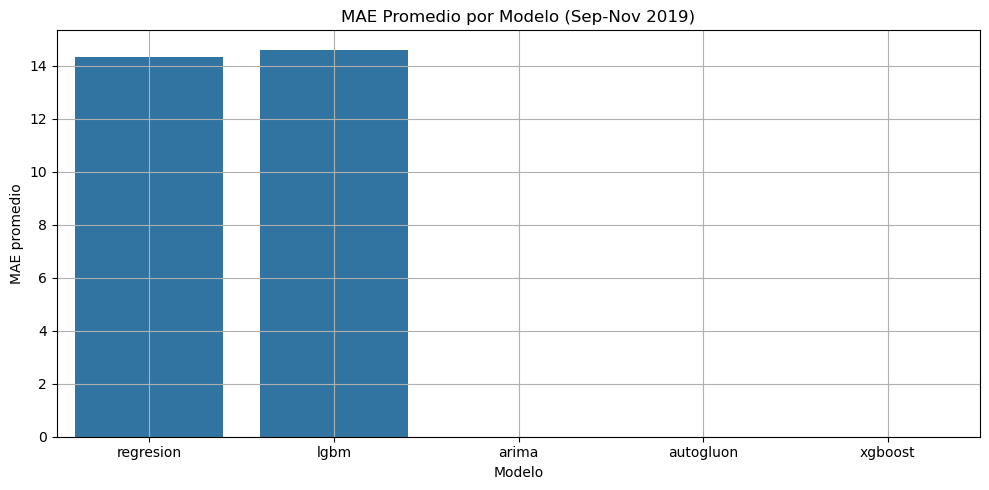

In [ ]:
#cambio fuente de datos por datos_finales.txt
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
import xgboost as xgb
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import contextlib
import sys

warnings.filterwarnings("ignore")

# 🔇 Context manager para silenciar outputs de LightGBM
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout, sys.stderr = devnull, devnull
        try:
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr

# 1. Cargar dataset final con features y stocks
df = pd.read_csv("datos_finales.txt", sep="\t")
df['periodo'] = pd.to_datetime(df['periodo'])

df = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 2. Cargar listado fijo de productos
with open("product_id_apredecir201912.TXT", "r") as f:
    productos = [int(line.strip()) for line in f if line.strip().isdigit()]

# 3. Inicializar salida
resultados, log, maes_resumen = [], [], []
os.makedirs("autogluon_temp_ts", exist_ok=True)
productos_predichos = set()

# 4. Loop por producto
for prod in tqdm(productos, desc="Procesando productos"):
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    datos['mes'] = datos['periodo'].dt.month

    train = datos[datos['periodo'] < '2019-09-01'].copy()
    val = datos[datos['periodo'].isin([
        pd.Timestamp('2019-09-01'),
        pd.Timestamp('2019-10-01'),
        pd.Timestamp('2019-11-01')
    ])].copy()

    if len(train) < 12 or val.empty:
        continue

    X_train = train[['mes']]
    y_train = train['tn']
    X_val = val[['mes']]
    y_val = val['tn']

    maes, preds = {}, {}

    # 1. Regresión lineal
    try:
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_val)
        maes['regresion'] = mean_absolute_error(y_val, y_pred)
        preds['regresion'] = lr.predict([[2]])[0]
    except:
        maes['regresion'] = np.inf

    # 2. ARIMA
    try:
        serie = train.set_index('periodo')['tn']
        modelo_arima = ARIMA(serie, order=(1, 1, 1)).fit()
        y_pred = modelo_arima.forecast(steps=3)
        maes['arima'] = mean_absolute_error(y_val.values, y_pred.values)
        feb_pred = modelo_arima.forecast(steps=5)[-1]
        preds['arima'] = feb_pred
    except:
        maes['arima'] = np.inf

    # 3. LightGBM (muteado)
    try:
        with suppress_output():
            lgb_model = lgb.LGBMRegressor(
                n_estimators=834,
                learning_rate=0.06449926163783713,
                max_depth=13,
                num_leaves=197,
                min_data_in_leaf=208,
                min_child_weight=3.7932779938198546,
                subsample=0.7032151245633396,
                subsample_freq=7,
                colsample_bytree=0.9893937066314805,
                colsample_bynode=0.8148358693555268,
                reg_alpha=4.962755134948597,
                reg_lambda=3.8191748367071927,
                max_bin=512,
                min_split_gain=0.006311109685921704,
                cat_smooth=49.82693114488869,
                random_state=42,
                boosting_type='dart',
                verbosity=-1,
                linear_tree=True
            )
            lgb_model.fit(X_train, y_train)
        y_pred = lgb_model.predict(X_val)
        maes['lgbm'] = mean_absolute_error(y_val, y_pred)
        preds['lgbm'] = lgb_model.predict([[2]])[0]
    except:
        maes['lgbm'] = np.inf

    # 4. XGBoost
    try:
        xgb_model = xgb.XGBRegressor(verbosity=0)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_val)
        maes['xgboost'] = mean_absolute_error(y_val, y_pred)
        preds['xgboost'] = xgb_model.predict([[2]])[0]
    except:
        maes['xgboost'] = np.inf

    # 5. AutoGluon
    try:
        df_serie = train[['periodo', 'tn']].copy()
        df_serie['item_id'] = str(prod)
        df_serie = df_serie.rename(columns={'periodo': 'timestamp'})
        df_serie = df_serie[['item_id', 'timestamp', 'tn']]

        ts_data = TimeSeriesDataFrame.from_data_frame(
            df_serie, id_column='item_id', timestamp_column='timestamp'
        ).fill_missing_values()

        predictor = TimeSeriesPredictor(
            prediction_length=5,
            target='tn',
            freq='MS',
            eval_metric='MASE',
            path=f"autogluon_temp_ts/{prod}",
            verbosity=0
        )

        predictor.fit(
            ts_data,
            num_val_windows=2,
            time_limit=5*60,
            enable_ensemble=False,
            hyperparameters={"ETS": {}, "AutoARIMA": {}, "Naive": {}}
        )

        forecast = predictor.predict(ts_data)
        val_preds = [forecast.loc[(str(prod), pd.Timestamp(d)), 'mean'] for d in ['2019-09-01', '2019-10-01', '2019-11-01']]
        maes['autogluon'] = mean_absolute_error(y_val, val_preds)
        preds['autogluon'] = forecast.loc[(str(prod), pd.Timestamp("2020-02-01")), 'mean']
    except:
        maes['autogluon'] = np.inf

    mejor_modelo = min(maes, key=maes.get)
    pred_final = preds[mejor_modelo]
    resultados.append({'product_id': prod, 'tn_predicho': pred_final})
    productos_predichos.add(prod)
    log.append(f"Producto {prod}: mejor modelo = {mejor_modelo}, MAE sep-nov = {maes[mejor_modelo]:.4f}")

    mae_row = {'product_id': prod}
    for modelo in ['regresion', 'arima', 'lgbm', 'xgboost', 'autogluon']:
        mae_row[f'mae_{modelo}'] = maes.get(modelo, np.nan)
    maes_resumen.append(mae_row)

# 6. Fallback
productos_faltantes = set(productos) - productos_predichos
for prod in productos_faltantes:
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    ultimos_12 = datos[datos['periodo'] < '2020-01-01'].tail(12)
    pred_fallback = ultimos_12['tn'].mean() if not ultimos_12.empty else 0
    resultados.append({'product_id': prod, 'tn_predicho': pred_fallback})
    log.append(f"Producto {prod}: fallback promedio últimos 12 meses = {pred_fallback:.2f}")

# 7. Guardar
pd.DataFrame(resultados).sort_values("product_id").to_csv("predicciones_febrero2020_porproducto8.csv", index=False)
maes_df = pd.DataFrame(maes_resumen).sort_values("product_id")
maes_df.to_csv("maes_por_modelo8.csv", index=False)
with open("log_modelos8.txt", "w") as f:
    for linea in log:
        f.write(linea + "\n")

# 8. Gráfico local
maes_long = maes_df.melt(id_vars='product_id', value_vars=[col for col in maes_df.columns if col.startswith('mae_')],
                         var_name='modelo', value_name='mae')
maes_long['modelo'] = maes_long['modelo'].str.replace('mae_', '')
mae_promedios = maes_long.groupby('modelo')['mae'].mean().reset_index().sort_values('mae')

plt.figure(figsize=(10, 5))
sns.barplot(data=mae_promedios, x='modelo', y='mae')
plt.title("MAE Promedio por Modelo (Sep-Nov 2019)")
plt.ylabel("MAE promedio")
plt.xlabel("Modelo")
plt.grid(True)
plt.tight_layout()
plt.savefig("grafico_mae_promedio.png")
plt.show()


In [ ]:
#validación ampliada a al 20% de los períodos. SIN AGOSTO NI EN TRAIN NI TEST. 0.333 en el public
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
import xgboost as xgb
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings("ignore")

# Context manager para silenciar outputs de LightGBM
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout, sys.stderr = devnull, devnull
        try:
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr

# 1. Cargar dataset
df = pd.read_csv("sell-in.txt", sep="\t")
df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')
df = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 2. Cargar listado fijo de productos
with open("product_id_apredecir201912.TXT", "r") as f:
    productos = [int(line.strip()) for line in f if line.strip().isdigit()]

# 3. Inicializar salida
resultados = []
log = []
maes_resumen = []

# 4. Carpeta autogluon
os.makedirs("autogluon_temp_ts", exist_ok=True)

productos_predichos = set()

# 5. Loop por producto
for prod in tqdm(productos, desc="Procesando productos"):
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    datos['mes'] = datos['periodo'].dt.month

    train = datos[datos['periodo'] < '2019-05-01'].copy()
    val = datos[datos['periodo'].isin([
        pd.Timestamp('2019-05-01'),
        pd.Timestamp('2019-06-01'),
        pd.Timestamp('2019-07-01'),
        pd.Timestamp('2019-09-01'),
        pd.Timestamp('2019-10-01'),
        pd.Timestamp('2019-11-01'),
        pd.Timestamp('2019-12-01')
    ])].copy()

    if len(train) < 12 or val.empty:
        continue

    X_train = train[['mes']]
    y_train = train['tn']
    X_val = val[['mes']]
    y_val = val['tn']

    maes = {}
    preds = {}

    # 1. Regresión lineal
    try:
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_val)
        maes['regresion'] = mean_absolute_error(y_val, y_pred)
        preds['regresion'] = lr.predict([[2]])[0]
    except:
        maes['regresion'] = np.inf

    # 2. ARIMA
    try:
        serie = train.set_index('periodo')['tn']
        modelo_arima = ARIMA(serie, order=(1, 1, 1)).fit()
        y_pred = modelo_arima.forecast(steps=3)
        maes['arima'] = mean_absolute_error(y_val.values, y_pred.values)
        feb_pred = modelo_arima.forecast(steps=5)[-1]
        preds['arima'] = feb_pred
    except:
        maes['arima'] = np.inf

    # 3. LightGBM
    try:
        lgb_model = lgb.LGBMRegressor(
            n_estimators=834,
            learning_rate=0.06449926163783713,
            max_depth=13,
            num_leaves=197,
            min_data_in_leaf=208,
            min_child_weight=3.7932779938198546,
            subsample=0.7032151245633396,
            subsample_freq=7,
            colsample_bytree=0.9893937066314805,
            colsample_bynode=0.8148358693555268,
            reg_alpha=4.962755134948597,
            reg_lambda=3.8191748367071927,
            max_bin=512,
            min_split_gain=0.006311109685921704,
            cat_smooth=49.82693114488869,
            random_state=42,
            boosting_type='dart',
            verbosity=-1,
            linear_tree=True
        )
        lgb_model.fit(X_train, y_train)
        y_pred = lgb_model.predict(X_val)
        maes['lgbm'] = mean_absolute_error(y_val, y_pred)
        preds['lgbm'] = lgb_model.predict([[2]])[0]
    except:
        maes['lgbm'] = np.inf

    # 4. XGBoost
    try:
        xgb_model = xgb.XGBRegressor(verbosity=0)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_val)
        maes['xgboost'] = mean_absolute_error(y_val, y_pred)
        preds['xgboost'] = xgb_model.predict([[2]])[0]
    except:
        maes['xgboost'] = np.inf

    # 5. AutoGluon
    try:
        df_serie = train[['periodo', 'tn']].copy()
        df_serie['item_id'] = str(prod)
        df_serie = df_serie.rename(columns={'periodo': 'timestamp'})
        df_serie = df_serie[['item_id', 'timestamp', 'tn']]

        ts_data = TimeSeriesDataFrame.from_data_frame(
            df_serie, id_column='item_id', timestamp_column='timestamp'
        ).fill_missing_values()

        predictor = TimeSeriesPredictor(
            prediction_length=5,
            target='tn',
            freq='MS',
            eval_metric='MASE',
            path=f"autogluon_temp_ts/{prod}",
            verbosity=0
        )

        predictor.fit(
            ts_data,
            num_val_windows=2,
            time_limit=60,
            enable_ensemble=False,
            hyperparameters={"ETS": {}, "AutoARIMA": {}, "Naive": {}}
        )

        forecast = predictor.predict(ts_data)
        val_preds = [forecast.loc[(str(prod), pd.Timestamp(d)), 'mean'] for d in ['2019-09-01', '2019-10-01', '2019-11-01']]
        maes['autogluon'] = mean_absolute_error(y_val, val_preds)
        preds['autogluon'] = forecast.loc[(str(prod), pd.Timestamp("2020-02-01")), 'mean']
    except:
        maes['autogluon'] = np.inf

    mejor_modelo = min(maes, key=maes.get)
    pred_final = preds[mejor_modelo]
    resultados.append({'product_id': prod, 'tn_predicho': pred_final})
    productos_predichos.add(prod)
    log.append(f"Producto {prod}: mejor modelo = {mejor_modelo}, MAE sep-nov = {maes[mejor_modelo]:.4f}")

    mae_row = {'product_id': prod}
    for modelo in ['regresion', 'arima', 'lgbm', 'xgboost', 'autogluon']:
        mae_row[f'mae_{modelo}'] = maes.get(modelo, np.nan)
    maes_resumen.append(mae_row)

# 6. Fallback
productos_faltantes = set(productos) - productos_predichos
for prod in productos_faltantes:
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    ultimos_12 = datos[datos['periodo'] < '2020-01-01'].tail(12)
    pred_fallback = ultimos_12['tn'].mean() if not ultimos_12.empty else 0
    resultados.append({'product_id': prod, 'tn_predicho': pred_fallback})
    log.append(f"Producto {prod}: fallback promedio últimos 12 meses = {pred_fallback:.2f}")

# 7. Guardar
pd.DataFrame(resultados).sort_values("product_id").to_csv("predicciones_febrero2020_porproducto9.csv", index=False)
maes_df = pd.DataFrame(maes_resumen).sort_values("product_id")
maes_df.to_csv("maes_por_modelo9.csv", index=False)
with open("log_modelos9.txt", "w") as f:
    for linea in log:
        f.write(linea + "\n")

# 8. Gráfico local
maes_long = maes_df.melt(id_vars='product_id', value_vars=[col for col in maes_df.columns if col.startswith('mae_')],
                         var_name='modelo', value_name='mae')
maes_long['modelo'] = maes_long['modelo'].str.replace('mae_', '')
mae_promedios = maes_long.groupby('modelo')['mae'].mean().reset_index().sort_values('mae')

plt.figure(figsize=(10, 5))
sns.barplot(data=mae_promedios, x='modelo', y='mae')
plt.title("MAE Promedio por Modelo (Sep-Nov 2019)")
plt.ylabel("MAE promedio")
plt.xlabel("Modelo")
plt.grid(True)
plt.tight_layout()
plt.savefig("grafico_mae_promedio.png")
plt.show()


In [ ]:
#mejor rendimiento en public, modificando regresión x los mágicos del profesor. 0.289 en public
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
import xgboost as xgb
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
import contextlib

warnings.filterwarnings("ignore")

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout, sys.stderr = devnull, devnull
        try:
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr

# 1. Cargar dataset
df = pd.read_csv("sell-in.txt", sep="\t")
df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')
df = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()
df_pivot = df.pivot(index="periodo", columns="product_id", values="tn").reset_index()

# 2. Lista fija de productos mágicos
magicos = [20002, 20003, 20006, 20010, 20011, 20018, 20019, 20021,
           20026, 20028, 20035, 20039, 20042, 20044, 20045, 20046,
           20049, 20051, 20052, 20053, 20055, 20008, 20001, 20017,
           20086, 20180, 20193, 20320, 20532, 20612, 20637, 20807, 20838]

# 3. Cargar listado de productos a predecir
with open("product_id_apredecir201912.TXT", "r") as f:
    productos = [int(line.strip()) for line in f if line.strip().isdigit()]

resultados = []
log = []
maes_resumen = []
os.makedirs("autogluon_temp_ts", exist_ok=True)
productos_predichos = set()

for prod in tqdm(productos, desc="Procesando productos"):
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    datos['mes'] = datos['periodo'].dt.month

    train = datos[datos['periodo'] < '2019-09-01'].copy()
    val = datos[datos['periodo'].isin([
        pd.Timestamp('2019-09-01'),
        pd.Timestamp('2019-10-01'),
        pd.Timestamp('2019-11-01')
    ])].copy()

    if len(train) < 12 or val.empty:
        continue

    maes = {}
    preds = {}

    # 1. Reemplazo: regresión basada en productos mágicos
    try:
        # Construir X_train con mágicos en 2018
        X_train = df_pivot[df_pivot['periodo'].between('2018-01-01', '2018-12-31')][magicos]
        X_train = X_train.T
        X_train.columns = [f"t-{11-k}" for k in range(12)]

        # Variable objetivo: tn de febrero 2019 del producto
        y_target = df[(df['product_id'] == prod) & (df['periodo'] == '2019-02-01')]['tn']
        if y_target.empty:
            raise ValueError("Sin dato objetivo para febrero 2019")
        y_train = y_target.values

        # X_pred: mágicos en 2019 para predecir febrero 2020
        X_pred = df_pivot[df_pivot['periodo'].between('2019-01-01', '2019-12-31')][magicos]
        X_pred = X_pred.T
        X_pred.columns = [f"t-{11-k}" for k in range(12)]

        lr = LinearRegression()
        lr.fit(X_train, y_train)
        pred_feb2020 = lr.predict(X_pred)[0]

        # Validación: usar mágicos 2018 → febrero 2019 vs real
        maes['regresion'] = mean_absolute_error(y_train, lr.predict(X_train))
        preds['regresion'] = pred_feb2020
    except:
        maes['regresion'] = np.inf

    # 2. ARIMA
    try:
        serie = train.set_index('periodo')['tn']
        modelo_arima = ARIMA(serie, order=(1, 1, 1)).fit()
        y_pred = modelo_arima.forecast(steps=3)
        maes['arima'] = mean_absolute_error(val['tn'].values, y_pred.values)
        feb_pred = modelo_arima.forecast(steps=5)[-1]
        preds['arima'] = feb_pred
    except:
        maes['arima'] = np.inf

    # 3. LightGBM
    try:
        X_train_simple = train[['mes']]
        y_train_simple = train['tn']
        X_val_simple = val[['mes']]
        y_val_simple = val['tn']

        lgb_model = lgb.LGBMRegressor(
            n_estimators=834,
            learning_rate=0.06449926163783713,
            max_depth=13,
            num_leaves=197,
            min_data_in_leaf=208,
            min_child_weight=3.7932779938198546,
            subsample=0.7032151245633396,
            subsample_freq=7,
            colsample_bytree=0.9893937066314805,
            colsample_bynode=0.8148358693555268,
            reg_alpha=4.962755134948597,
            reg_lambda=3.8191748367071927,
            max_bin=512,
            min_split_gain=0.006311109685921704,
            cat_smooth=49.82693114488869,
            random_state=42,
            boosting_type='dart',
            verbosity=-1,
            linear_tree=True
        )
        lgb_model.fit(X_train_simple, y_train_simple)
        y_pred = lgb_model.predict(X_val_simple)
        maes['lgbm'] = mean_absolute_error(y_val_simple, y_pred)
        preds['lgbm'] = lgb_model.predict([[2]])[0]
    except:
        maes['lgbm'] = np.inf

    # 4. XGBoost
    try:
        xgb_model = xgb.XGBRegressor(verbosity=0)
        xgb_model.fit(X_train_simple, y_train_simple)
        y_pred = xgb_model.predict(X_val_simple)
        maes['xgboost'] = mean_absolute_error(y_val_simple, y_pred)
        preds['xgboost'] = xgb_model.predict([[2]])[0]
    except:
        maes['xgboost'] = np.inf

    # 5. AutoGluon
    try:
        df_serie = train[['periodo', 'tn']].copy()
        df_serie['item_id'] = str(prod)
        df_serie = df_serie.rename(columns={'periodo': 'timestamp'})
        df_serie = df_serie[['item_id', 'timestamp', 'tn']]

        ts_data = TimeSeriesDataFrame.from_data_frame(
            df_serie, id_column='item_id', timestamp_column='timestamp'
        ).fill_missing_values()

        predictor = TimeSeriesPredictor(
            prediction_length=5,
            target='tn',
            freq='MS',
            eval_metric='MASE',
            path=f"autogluon_temp_ts/{prod}",
            verbosity=0
        )

        predictor.fit(
            ts_data,
            num_val_windows=2,
            time_limit=60,
            enable_ensemble=False,
            hyperparameters={"ETS": {}, "AutoARIMA": {}, "Naive": {}}
        )

        forecast = predictor.predict(ts_data)
        val_preds = [forecast.loc[(str(prod), pd.Timestamp(d)), 'mean'] for d in ['2019-09-01', '2019-10-01', '2019-11-01']]
        maes['autogluon'] = mean_absolute_error(val['tn'], val_preds)
        preds['autogluon'] = forecast.loc[(str(prod), pd.Timestamp("2020-02-01")), 'mean']
    except:
        maes['autogluon'] = np.inf

    mejor_modelo = min(maes, key=maes.get)
    pred_final = preds[mejor_modelo]
    resultados.append({'product_id': prod, 'tn_predicho': pred_final})
    productos_predichos.add(prod)
    log.append(f"Producto {prod}: mejor modelo = {mejor_modelo}, MAE sep-nov = {maes[mejor_modelo]:.4f}")

    mae_row = {'product_id': prod}
    for modelo in ['regresion', 'arima', 'lgbm', 'xgboost', 'autogluon']:
        mae_row[f'mae_{modelo}'] = maes.get(modelo, np.nan)
    maes_resumen.append(mae_row)

# Fallback para productos no predichos
productos_faltantes = set(productos) - productos_predichos
for prod in productos_faltantes:
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    ultimos_12 = datos[datos['periodo'] < '2020-01-01'].tail(12)
    pred_fallback = ultimos_12['tn'].mean() if not ultimos_12.empty else 0
    resultados.append({'product_id': prod, 'tn_predicho': pred_fallback})
    log.append(f"Producto {prod}: fallback promedio últimos 12 meses = {pred_fallback:.2f}")

# Guardar resultados
pd.DataFrame(resultados).sort_values("product_id").to_csv("predicciones_febrero2020_porproducto10.csv", index=False)
maes_df = pd.DataFrame(maes_resumen).sort_values("product_id")
maes_df.to_csv("maes_por_modelo10.csv", index=False)
with open("log_modelos10.txt", "w") as f:
    for linea in log:
        f.write(linea + "\n")

# Gráfico local
maes_long = maes_df.melt(id_vars='product_id', value_vars=[col for col in maes_df.columns if col.startswith('mae_')],
                         var_name='modelo', value_name='mae')
maes_long['modelo'] = maes_long['modelo'].str.replace('mae_', '')
mae_promedios = maes_long.groupby('modelo')['mae'].mean().reset_index().sort_values('mae')

plt.figure(figsize=(10, 5))
sns.barplot(data=mae_promedios, x='modelo', y='mae')
plt.title("MAE Promedio por Modelo (Sep-Nov 2019)")
plt.ylabel("MAE promedio")
plt.xlabel("Modelo")
plt.grid(True)
plt.tight_layout()
plt.savefig("grafico_mae_promedio.png")
plt.show()



In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
import xgboost as xgb
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
import contextlib

warnings.filterwarnings("ignore")

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout, sys.stderr = devnull, devnull
        try:
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr

# 1. Cargar dataset
print("Cargando datos...")
df = pd.read_csv("sell-in.txt", sep="\t")
df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')
df = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()
df_pivot = df.pivot(index="periodo", columns="product_id", values="tn").reset_index()

# 2. Productos mágicos
magicos = [20002, 20003, 20006, 20010, 20011, 20018, 20019, 20021, 20026, 20028,
           20035, 20039, 20042, 20044, 20045, 20046, 20049, 20051, 20052, 20053,
           20055, 20008, 20001, 20017, 20086, 20180, 20193, 20320, 20532, 20612,
           20637, 20807, 20838]

# 3. Cargar productos a predecir
with open("product_id_apredecir201912.TXT", "r") as f:
    productos = [int(line.strip()) for line in f if line.strip().isdigit()]

resultados, log, maes_resumen = [], [], []
os.makedirs("autogluon_temp_ts", exist_ok=True)
productos_predichos = set()

for prod in tqdm(productos, desc="Procesando productos"):
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    datos['mes'] = datos['periodo'].dt.month

    train = datos[datos['periodo'] < '2019-09-01'].copy()
    val = datos[datos['periodo'].isin([
        pd.Timestamp('2019-09-01'), pd.Timestamp('2019-10-01'), pd.Timestamp('2019-11-01')
    ])].copy()

    if len(train) < 12 or val.empty:
        continue

    maes, preds = {}, {}

    # Regresión con mágicos
    try:
        X_train = df_pivot[df_pivot['periodo'].between('2018-01-01', '2018-12-31')][magicos].T
        X_train.columns = [f"t-{11-k}" for k in range(12)]
        X_pred = df_pivot[df_pivot['periodo'].between('2019-01-01', '2019-12-31')][magicos].T
        X_pred.columns = [f"t-{11-k}" for k in range(12)]
        y_target = df[(df['product_id'] == prod) & (df['periodo'] == '2019-02-01')]['tn']
        if y_target.empty or X_train.isnull().any().any() or X_pred.isnull().any().any(): raise ValueError()
        lr = LinearRegression().fit(X_train, y_target.values)
        maes['regresion'] = mean_absolute_error(y_target.values, lr.predict(X_train))
        preds['regresion'] = lr.predict(X_pred)[0]
    except:
        maes['regresion'] = np.inf

    # ARIMA
    try:
        serie = train.set_index('periodo')['tn']
        modelo_arima = ARIMA(serie, order=(1,1,1)).fit()
        y_pred = modelo_arima.forecast(steps=3)
        maes['arima'] = mean_absolute_error(val['tn'].values, y_pred.values)
        preds['arima'] = modelo_arima.forecast(steps=5)[-1]
    except:
        maes['arima'] = np.inf

    # LightGBM
    try:
        X_train_lgb, y_train_lgb = train[['mes']], train['tn']
        X_val_lgb, y_val_lgb = val[['mes']], val['tn']
        lgb_model = lgb.LGBMRegressor(
            n_estimators=834,
            learning_rate=0.0645,
            max_depth=13,
            num_leaves=197,
            min_data_in_leaf=208,
            subsample=0.7032,
            subsample_freq=7,
            colsample_bytree=0.9894,
            colsample_bynode=0.8148,
            reg_alpha=4.9628,
            reg_lambda=3.8192,
            max_bin=512,
            min_split_gain=0.0063,
            cat_smooth=49.8269,
            random_state=42,
            boosting_type='dart',
            verbosity=-1,
            linear_tree=True,
            #min_child_samples=20
        )
        lgb_model.fit(X_train_lgb, y_train_lgb)
        y_pred = lgb_model.predict(X_val_lgb)
        maes['lgbm'] = mean_absolute_error(y_val_lgb, y_pred)
        preds['lgbm'] = lgb_model.predict([[2]])[0]
    except:
        maes['lgbm'] = np.inf

    # XGBoost
    try:
        if len(X_train_lgb) >= 2:
            xgb_model = xgb.XGBRegressor(verbosity=0)
            xgb_model.fit(X_train_lgb, y_train_lgb)
            y_pred = xgb_model.predict(X_val_lgb)
            maes['xgboost'] = mean_absolute_error(y_val_lgb, y_pred)
            preds['xgboost'] = xgb_model.predict([[2]])[0]
        else:
            maes['xgboost'] = np.inf
    except:
        maes['xgboost'] = np.inf

    # AutoGluon
    try:
        if len(train) >= 4:
            df_serie = train[['periodo', 'tn']].copy()
            df_serie['item_id'] = str(prod)
            df_serie = df_serie.rename(columns={'periodo': 'timestamp'})[['item_id', 'timestamp', 'tn']]
            ts_data = TimeSeriesDataFrame.from_data_frame(df_serie, id_column='item_id', timestamp_column='timestamp').fill_missing_values()
            predictor = TimeSeriesPredictor(prediction_length=5, target='tn', freq='MS', eval_metric='MASE', path=f"autogluon_temp_ts/{prod}", verbosity=0)
            predictor.fit(ts_data, num_val_windows=2, time_limit=5*60, enable_ensemble=False, hyperparameters={"ETS": {}, "AutoARIMA": {}, "Naive": {}})
            forecast = predictor.predict(ts_data)
            val_preds = [forecast.loc[(str(prod), pd.Timestamp(d)), 'mean'] for d in ['2019-09-01','2019-10-01','2019-11-01']]
            maes['autogluon'] = mean_absolute_error(val['tn'], val_preds)
            preds['autogluon'] = forecast.loc[(str(prod), pd.Timestamp("2020-02-01")), 'mean']
        else:
            maes['autogluon'] = np.inf
    except:
        maes['autogluon'] = np.inf

    mejor_modelo = min(maes, key=maes.get)
    resultados.append({'product_id': prod, 'tn_predicho': preds[mejor_modelo]})
    productos_predichos.add(prod)
    log.append(f"Producto {prod}: mejor modelo = {mejor_modelo}, MAE sep-nov = {maes[mejor_modelo]:.4f}")
    mae_row = {'product_id': prod}
    for modelo in ['regresion','arima','lgbm','xgboost','autogluon']:
        mae_row[f'mae_{modelo}'] = maes.get(modelo, np.nan)
    maes_resumen.append(mae_row)

# Fallback
productos_faltantes = set(productos) - productos_predichos
for prod in productos_faltantes:
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    ultimos_12 = datos[datos['periodo'] < '2020-01-01'].tail(12)
    pred_fallback = ultimos_12['tn'].mean() if not ultimos_12.empty else 0
    resultados.append({'product_id': prod, 'tn_predicho': pred_fallback})
    log.append(f"Producto {prod}: fallback promedio últimos 12 meses = {pred_fallback:.2f}")

# Guardar
pd.DataFrame(resultados).sort_values("product_id").to_csv("predicciones_febrero2020_porproducto11.csv", index=False)
pd.DataFrame(maes_resumen).sort_values("product_id").to_csv("maes_por_modelo11.csv", index=False)
with open("log_modelos11.txt", "w") as f:
    for linea in log:
        f.write(linea + "\n")

# Gráfico MAE promedio
maes_df = pd.DataFrame(maes_resumen)
maes_long = maes_df.melt(id_vars='product_id', value_vars=[col for col in maes_df.columns if col.startswith('mae_')],
                         var_name='modelo', value_name='mae')
maes_long['modelo'] = maes_long['modelo'].str.replace('mae_', '')
mae_promedios = maes_long.groupby('modelo')['mae'].mean().reset_index().sort_values('mae')

plt.figure(figsize=(10, 5))
sns.barplot(data=mae_promedios, x='modelo', y='mae')
plt.title("MAE Promedio por Modelo (Sep-Nov 2019)")
plt.ylabel("MAE promedio")
plt.xlabel("Modelo")
plt.grid(True)
plt.tight_layout()
plt.savefig("grafico_mae_promedio.png")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
import xgboost as xgb
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
import contextlib

warnings.filterwarnings("ignore")

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout, sys.stderr = devnull, devnull
        try:
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr

# 1. Cargar dataset
print("Cargando datos...")
df = pd.read_csv("sell-in.txt", sep="\t")
df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')
df = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()
df_pivot = df.pivot(index="periodo", columns="product_id", values="tn").reset_index()

# 2. Productos mágicos
magicos = [20002, 20003, 20006, 20010, 20011, 20018, 20019, 20021, 20026, 20028,
           20035, 20039, 20042, 20044, 20045, 20046, 20049, 20051, 20052, 20053,
           20055, 20008, 20001, 20017, 20086, 20180, 20193, 20320, 20532, 20612,
           20637, 20807, 20838]

# Entrenar regresion global con magicos
m2018 = df_pivot[df_pivot["periodo"].between("2018-01-01", "2018-12-31")][magicos].T
m2018.columns = [f"t-{11-k}" for k in range(12)]
feb2019 = df_pivot[df_pivot["periodo"] == "2019-02-01"][magicos].T
feb2019.columns = ["target"]
regresion_magicos = LinearRegression()
regresion_magicos.fit(m2018, feb2019["target"])

# 3. Cargar productos a predecir
with open("product_id_apredecir201912.TXT", "r") as f:
    productos = [int(line.strip()) for line in f if line.strip().isdigit()]

resultados, log, maes_resumen = [], [], []
os.makedirs("autogluon_temp_ts", exist_ok=True)
productos_predichos = set()

for prod in tqdm(productos, desc="Procesando productos"):
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    datos['mes'] = datos['periodo'].dt.month

    train = datos[datos['periodo'] < '2019-09-01'].copy()
    val = datos[datos['periodo'].isin([
        pd.Timestamp('2019-09-01'), pd.Timestamp('2019-10-01'), pd.Timestamp('2019-11-01')
    ])].copy()

    if len(train) < 12 or val.empty:
        continue

    maes, preds = {}, {}

    # Aplicar regresion global con magicos
    try:
        m2019 = df_pivot[df_pivot["periodo"].between("2019-01-01", "2019-12-31")][magicos].T
        m2019.columns = [f"t-{11-k}" for k in range(12)]
        if m2019.isnull().any().any(): raise ValueError()
        x_pred = m2019.values.reshape(1, -1)
        pred_feb2020 = regresion_magicos.predict(x_pred)[0]
        pred_feb2019 = regresion_magicos.predict(m2018)
        maes["regresion"] = mean_absolute_error(feb2019["target"], pred_feb2019)
        preds["regresion"] = pred_feb2020
    except:
        maes["regresion"] = np.inf

    # ARIMA
    try:
        serie = train.set_index('periodo')['tn']
        modelo_arima = ARIMA(serie, order=(1,1,1)).fit()
        y_pred = modelo_arima.forecast(steps=3)
        maes['arima'] = mean_absolute_error(val['tn'].values, y_pred.values)
        preds['arima'] = modelo_arima.forecast(steps=5)[-1]
    except:
        maes['arima'] = np.inf

    # LightGBM
    try:
        X_train_lgb, y_train_lgb = train[['mes']], train['tn']
        X_val_lgb, y_val_lgb = val[['mes']], val['tn']
        lgb_model = lgb.LGBMRegressor(
            n_estimators=834,
            learning_rate=0.0645,
            max_depth=13,
            num_leaves=197,
            min_data_in_leaf=208,
            subsample=0.7032,
            subsample_freq=7,
            colsample_bytree=0.9894,
            colsample_bynode=0.8148,
            reg_alpha=4.9628,
            reg_lambda=3.8192,
            max_bin=512,
            min_split_gain=0.0063,
            cat_smooth=49.8269,
            random_state=42,
            boosting_type='dart',
            verbosity=-1,
            linear_tree=True
        )
        lgb_model.fit(X_train_lgb, y_train_lgb)
        y_pred = lgb_model.predict(X_val_lgb)
        maes['lgbm'] = mean_absolute_error(y_val_lgb, y_pred)
        preds['lgbm'] = lgb_model.predict([[2]])[0]
    except:
        maes['lgbm'] = np.inf

    # XGBoost
    try:
        if len(X_train_lgb) >= 2 and y_train_lgb.nunique() > 1:

            xgb_model = xgb.XGBRegressor(verbosity=0)
            xgb_model.fit(X_train_lgb, y_train_lgb)
            y_pred = xgb_model.predict(X_val_lgb)
            maes['xgboost'] = mean_absolute_error(y_val_lgb, y_pred)
            preds['xgboost'] = xgb_model.predict([[2]])[0]
        else:
            maes['xgboost'] = np.inf
    except:
        maes['xgboost'] = np.inf

    # AutoGluon
    try:
        if len(train) >= 4 and train["tn"].gt(0).sum() >= 3:

            df_serie = train[['periodo', 'tn']].copy()
            df_serie['item_id'] = str(prod)
            df_serie = df_serie.rename(columns={'periodo': 'timestamp'})[['item_id', 'timestamp', 'tn']]
            ts_data = TimeSeriesDataFrame.from_data_frame(df_serie, id_column='item_id', timestamp_column='timestamp').fill_missing_values()
            predictor = TimeSeriesPredictor(prediction_length=5, target='tn', freq='MS', eval_metric='MASE', path=f"autogluon_temp_ts/{prod}", verbosity=0)
            predictor.fit(ts_data, num_val_windows=2, time_limit=5*60, enable_ensemble=False, hyperparameters={"ETS": {}, "AutoARIMA": {}, "Naive": {}})
            forecast = predictor.predict(ts_data)
            val_preds = [forecast.loc[(str(prod), pd.Timestamp(d)), 'mean'] for d in ['2019-09-01','2019-10-01','2019-11-01']]
            maes['autogluon'] = mean_absolute_error(val['tn'], val_preds)
            preds['autogluon'] = forecast.loc[(str(prod), pd.Timestamp("2020-02-01")), 'mean']
        else:
            maes['autogluon'] = np.inf
    except:
        maes['autogluon'] = np.inf

    mejor_modelo = min(maes, key=maes.get)
    resultados.append({'product_id': prod, 'tn_predicho': preds[mejor_modelo]})
    productos_predichos.add(prod)
    log.append(f"Producto {prod}: mejor modelo = {mejor_modelo}, MAE sep-nov = {maes[mejor_modelo]:.4f}")
    mae_row = {'product_id': prod}
    for modelo in ['regresion','arima','lgbm','xgboost','autogluon']:
        mae_row[f'mae_{modelo}'] = maes.get(modelo, np.nan)
    maes_resumen.append(mae_row)

# Fallback
productos_faltantes = set(productos) - productos_predichos
for prod in productos_faltantes:
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    ultimos_12 = datos[datos['periodo'] < '2020-01-01'].tail(12)
    pred_fallback = ultimos_12['tn'].mean() if not ultimos_12.empty else 0
    resultados.append({'product_id': prod, 'tn_predicho': pred_fallback})
    log.append(f"Producto {prod}: fallback promedio últimos 12 meses = {pred_fallback:.2f}")

# Guardar
pd.DataFrame(resultados).sort_values("product_id").to_csv("predicciones_febrero2020_porproducto12.csv", index=False)
pd.DataFrame(maes_resumen).sort_values("product_id").to_csv("maes_por_modelo12.csv", index=False)
with open("log_modelos12.txt", "w") as f:
    for linea in log:
        f.write(linea + "\n")

# Gráfico MAE promedio
maes_df = pd.DataFrame(maes_resumen)
maes_long = maes_df.melt(id_vars='product_id', value_vars=[col for col in maes_df.columns if col.startswith('mae_')],
                         var_name='modelo', value_name='mae')
maes_long['modelo'] = maes_long['modelo'].str.replace('mae_', '')
mae_promedios = maes_long.groupby('modelo')['mae'].mean().reset_index().sort_values('mae')

plt.figure(figsize=(10, 5))
sns.barplot(data=mae_promedios, x='modelo', y='mae')
plt.title("MAE Promedio por Modelo (Sep-Nov 2019)")
plt.ylabel("MAE promedio")
plt.xlabel("Modelo")
plt.grid(True)
plt.tight_layout()
plt.savefig("grafico_mae_promedio.png")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
import xgboost as xgb
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
import contextlib

warnings.filterwarnings("ignore")

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout, sys.stderr = devnull, devnull
        try:
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr

# 1. Cargar dataset
print("Cargando datos...")
df = pd.read_csv("sell-in.txt", sep="\t")
df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')
df = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()
df_pivot = df.pivot(index="periodo", columns="product_id", values="tn").reset_index()

# 2. Productos mágicos
magicos = [20002, 20003, 20006, 20010, 20011, 20018, 20019, 20021, 20026, 20028,
           20035, 20039, 20042, 20044, 20045, 20046, 20049, 20051, 20052, 20053,
           20055, 20008, 20001, 20017, 20086, 20180, 20193, 20320, 20532, 20612,
           20637, 20807, 20838]

# Entrenar regresion global con magicos
m2018 = df_pivot[df_pivot["periodo"].between("2018-01-01", "2018-12-31")][magicos].T
m2018.columns = [f"t-{11-k}" for k in range(12)]
feb2019 = df_pivot[df_pivot["periodo"] == "2019-02-01"][magicos].T
feb2019.columns = ["target"]
regresion_magicos = LinearRegression()
regresion_magicos.fit(m2018, feb2019["target"])

# 3. Cargar productos a predecir
with open("product_id_apredecir201912.TXT", "r") as f:
    productos = [int(line.strip()) for line in f if line.strip().isdigit()]

resultados, log, maes_resumen = [], [], []
os.makedirs("autogluon_temp_ts", exist_ok=True)
productos_predichos = set()

for prod in tqdm(productos, desc="Procesando productos"):
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    datos['mes'] = datos['periodo'].dt.month

    train = datos[datos['periodo'] < '2019-09-01'].copy()
    val = datos[datos['periodo'].isin([
        pd.Timestamp('2019-09-01'), pd.Timestamp('2019-10-01'), pd.Timestamp('2019-11-01')
    ])].copy()

    if len(train) < 12:
        continue

    if val.empty:
        maes = {
            "regresion": np.inf,
            "xgboost": np.inf,
            "autogluon": np.inf,
            "arima": np.inf,
            "lgbm": np.inf
        }
        resultados.append({'product_id': prod, 'tn_predicho': 0})
        productos_predichos.add(prod)
        log.append(f"Producto {prod}: sin datos de validación → todos los modelos = inf")
        mae_row = {'product_id': prod}
        for modelo in ['regresion','arima','lgbm','xgboost','autogluon']:
            mae_row[f'mae_{modelo}'] = maes.get(modelo, np.nan)
        maes_resumen.append(mae_row)    
        continue

    maes, preds = {}, {}

    # Ignorar productos magicos en estos modelos
    if prod in magicos:
        maes['regresion'] = np.inf
        maes['xgboost'] = np.inf
        maes['autogluon'] = np.inf
    else:
        # Aplicar regresion global con magicos
        try:
            m2019 = df_pivot[df_pivot["periodo"].between("2019-01-01", "2019-12-31")][magicos].T
            m2019.columns = [f"t-{11-k}" for k in range(12)]
            if m2019.isnull().any().any(): raise ValueError()
            x_pred = m2019.values.reshape(1, -1)
            pred_feb2020 = regresion_magicos.predict(x_pred)[0]
            pred_feb2019 = regresion_magicos.predict(m2018)
            maes["regresion"] = mean_absolute_error(feb2019["target"], pred_feb2019)
            preds["regresion"] = pred_feb2020
        except:
            maes["regresion"] = np.inf

        # XGBoost
        try:
            X_train_lgb, y_train_lgb = train[['mes']], train['tn']
            if len(X_train_lgb) >= 2 and y_train_lgb.nunique() > 1:
                xgb_model = xgb.XGBRegressor(verbosity=0)
                xgb_model.fit(X_train_lgb, y_train_lgb)
                y_pred = xgb_model.predict(val[['mes']])
                maes['xgboost'] = mean_absolute_error(val['tn'], y_pred)
                preds['xgboost'] = xgb_model.predict([[2]])[0]
            else:
                maes['xgboost'] = np.inf
        except:
            maes['xgboost'] = np.inf

        # AutoGluon
        try:
            if len(train) >= 4 and train['tn'].gt(0).sum() >= 3:
                df_serie = train[['periodo', 'tn']].copy()
                df_serie['item_id'] = str(prod)
                df_serie = df_serie.rename(columns={'periodo': 'timestamp'})[['item_id', 'timestamp', 'tn']]
                ts_data = TimeSeriesDataFrame.from_data_frame(df_serie, id_column='item_id', timestamp_column='timestamp').fill_missing_values()
                predictor = TimeSeriesPredictor(prediction_length=5, target='tn', freq='MS', eval_metric='MASE', path=f"autogluon_temp_ts/{prod}", verbosity=0)
                predictor.fit(ts_data, num_val_windows=2, time_limit=5*60, enable_ensemble=False, hyperparameters={"ETS": {}, "AutoARIMA": {}, "Naive": {}})
                forecast = predictor.predict(ts_data)
                val_preds = [forecast.loc[(str(prod), pd.Timestamp(d)), 'mean'] for d in ['2019-09-01','2019-10-01','2019-11-01']]
                maes['autogluon'] = mean_absolute_error(val['tn'], val_preds)
                preds['autogluon'] = forecast.loc[(str(prod), pd.Timestamp("2020-02-01")), 'mean']
            else:
                maes['autogluon'] = np.inf
        except:
            maes['autogluon'] = np.inf

    # ARIMA
    try:
        serie = train.set_index('periodo')['tn']
        modelo_arima = ARIMA(serie, order=(1,1,1)).fit()
        y_pred = modelo_arima.forecast(steps=3)
        maes['arima'] = mean_absolute_error(val['tn'].values, y_pred.values)
        preds['arima'] = modelo_arima.forecast(steps=5)[-1]
    except:
        maes['arima'] = np.inf

    # LightGBM
    try:
        X_train_lgb, y_train_lgb = train[['mes']], train['tn']
        X_val_lgb, y_val_lgb = val[['mes']], val['tn']
        lgb_model = lgb.LGBMRegressor(
            n_estimators=834,
            learning_rate=0.0645,
            max_depth=13,
            num_leaves=197,
            min_data_in_leaf=208,
            subsample=0.7032,
            subsample_freq=7,
            colsample_bytree=0.9894,
            colsample_bynode=0.8148,
            reg_alpha=4.9628,
            reg_lambda=3.8192,
            max_bin=512,
            min_split_gain=0.0063,
            cat_smooth=49.8269,
            random_state=42,
            boosting_type='dart',
            verbosity=-1,
            linear_tree=True
        )
        lgb_model.fit(X_train_lgb, y_train_lgb)
        y_pred = lgb_model.predict(X_val_lgb)
        maes['lgbm'] = mean_absolute_error(y_val_lgb, y_pred)
        preds['lgbm'] = lgb_model.predict([[2]])[0]
    except:
        maes['lgbm'] = np.inf

    mejor_modelo = min(maes, key=maes.get)
    resultados.append({'product_id': prod, 'tn_predicho': preds.get(mejor_modelo, 0)})
    productos_predichos.add(prod)
    log.append(f"Producto {prod}: mejor modelo = {mejor_modelo}, MAE sep-nov = {maes[mejor_modelo]:.4f}")
    mae_row = {'product_id': prod}
    for modelo in ['regresion','arima','lgbm','xgboost','autogluon']:
        mae_row[f'mae_{modelo}'] = maes.get(modelo, np.nan)
    maes_resumen.append(mae_row)

# Fallback
productos_faltantes = set(productos) - productos_predichos
for prod in productos_faltantes:
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    ultimos_12 = datos[datos['periodo'] < '2020-01-01'].tail(12)
    pred_fallback = ultimos_12['tn'].mean() if not ultimos_12.empty else 0
    resultados.append({'product_id': prod, 'tn_predicho': pred_fallback})
    log.append(f"Producto {prod}: fallback promedio últimos 12 meses = {pred_fallback:.2f}")

# Guardar
pd.DataFrame(resultados).sort_values("product_id").to_csv("predicciones_febrero2020_porproducto14.csv", index=False)
pd.DataFrame(maes_resumen).sort_values("product_id").to_csv("maes_por_modelo14.csv", index=False)
with open("log_modelos14.txt", "w") as f:
    for linea in log:
        f.write(linea + "\n")

# Gráfico MAE promedio
maes_df = pd.DataFrame(maes_resumen)
maes_long = maes_df.melt(id_vars='product_id', value_vars=[col for col in maes_df.columns if col.startswith('mae_')],
                         var_name='modelo', value_name='mae')
maes_long['modelo'] = maes_long['modelo'].str.replace('mae_', '')
mae_promedios = maes_long.groupby('modelo')['mae'].mean().reset_index().sort_values('mae')



In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
import xgboost as xgb
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
import contextlib

warnings.filterwarnings("ignore")

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout, sys.stderr = devnull, devnull
        try:
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr

# Verificar archivos necesarios
if not os.path.exists("sell-in.txt"):
    raise FileNotFoundError("No se encontró 'sell-in.txt'")
if not os.path.exists("product_id_apredecir201912.TXT"):
    raise FileNotFoundError("No se encontró 'product_id_apredecir201912.TXT'")

print("Cargando datos...")
try:
    df = pd.read_csv("sell-in.txt", sep="\t")
except Exception as e:
    raise RuntimeError(f"Error al leer 'sell-in.txt': {e}")

try:
    df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')
except Exception as e:
    raise RuntimeError(f"Error al convertir la columna 'periodo': {e}")

df = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()
df_pivot = df.pivot(index="periodo", columns="product_id", values="tn").reset_index()

magicos = [20002, 20003, 20006, 20010, 20011, 20018, 20019, 20021, 20026, 20028,
           20035, 20039, 20042, 20044, 20045, 20046, 20049, 20051, 20052, 20053,
           20055, 20008, 20001, 20017, 20086, 20180, 20193, 20320, 20532, 20612,
           20637, 20807, 20838]

# Filtrar solo los product_id mágicos disponibles en df_pivot
magicos_disponibles = [m for m in magicos if m in df_pivot.columns]

# Preparar matriz para regresión global con mágicos (2018)
m2018 = df_pivot[df_pivot["periodo"].between("2018-01-01", "2018-12-31")][magicos_disponibles].T
if m2018.shape[1] != 12:
    raise RuntimeError("No hay 12 meses de datos para productos mágicos en 2018")
m2018.columns = [f"t-{11-k}" for k in range(12)]

feb2019 = df_pivot[df_pivot["periodo"] == "2019-02-01"][magicos_disponibles].T
feb2019.columns = ["target"]

regresion_magicos = LinearRegression()
regresion_magicos.fit(m2018, feb2019["target"])

# Cargar productos a predecir
with open("product_id_apredecir201912.TXT", "r") as f:
    productos = [int(line.strip()) for line in f if line.strip().isdigit()]

resultados, log, maes_resumen = [], [], []
os.makedirs("autogluon_temp_ts", exist_ok=True)
productos_predichos = set()

for prod in tqdm(productos, desc="Procesando productos"):
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    datos['mes'] = datos['periodo'].dt.month

    train = datos[datos['periodo'] < '2019-09-01'].copy()
    val = datos[datos['periodo'].isin([
        pd.Timestamp('2019-09-01'), pd.Timestamp('2019-10-01'), pd.Timestamp('2019-11-01')
    ])].copy()

    if len(train) < 12:
        log.append(f"Producto {prod}: menos de 12 períodos de entrenamiento, resultado fallback.")
        maes = {k: np.inf for k in ['regresion','arima','lgbm','xgboost','autogluon']}
        resultados.append({'product_id': prod, 'tn_predicho': 0})
        mae_row = {'product_id': prod, **{f'mae_{k}': v for k,v in maes.items()}}
        maes_resumen.append(mae_row)
        productos_predichos.add(prod)
        continue

    if val.empty:
        maes = {k: np.inf for k in ['regresion','arima','lgbm','xgboost','autogluon']}
        resultados.append({'product_id': prod, 'tn_predicho': 0})
        log.append(f"Producto {prod}: sin datos de validación → todos los modelos = inf")
        mae_row = {'product_id': prod, **{f'mae_{k}': v for k,v in maes.items()}}
        maes_resumen.append(mae_row)
        productos_predichos.add(prod)
        continue

    maes, preds = {}, {}

    if prod in magicos_disponibles:
        maes['regresion'] = np.inf
        maes['xgboost'] = np.inf
        maes['autogluon'] = np.inf
    else:
        try:
            m2019 = df_pivot[df_pivot["periodo"].between("2019-01-01", "2019-12-31")][magicos_disponibles].T
            if m2019.shape[1] != 12 or m2019.isnull().any().any():
                raise ValueError("Datos incompletos o NaN para productos mágicos en 2019")
            m2019.columns = [f"t-{11-k}" for k in range(12)]
            x_pred = m2019.values.reshape(1, -1)
            pred_feb2020 = regresion_magicos.predict(x_pred)[0]
            pred_feb2019 = regresion_magicos.predict(m2018)
            maes["regresion"] = mean_absolute_error(feb2019["target"], pred_feb2019)
            preds["regresion"] = pred_feb2020
        except Exception as e:
            maes["regresion"] = np.inf
            log.append(f"Producto {prod}: error regresión global: {str(e)}")

        try:
            X_train_lgb, y_train_lgb = train[['mes']], train['tn']
            if len(X_train_lgb) >= 2 and y_train_lgb.nunique() > 1:
                xgb_model = xgb.XGBRegressor(verbosity=0)
                xgb_model.fit(X_train_lgb, y_train_lgb)
                y_pred = xgb_model.predict(val[['mes']])
                maes['xgboost'] = mean_absolute_error(val['tn'], y_pred)
                preds['xgboost'] = xgb_model.predict(np.array([[2]]))[0]
            else:
                maes['xgboost'] = np.inf
        except Exception as e:
            maes['xgboost'] = np.inf
            log.append(f"Producto {prod}: error XGBoost: {str(e)}")

        try:
            if len(train) >= 4 and train['tn'].gt(0).sum() >= 3:
                df_serie = train[['periodo', 'tn']].copy()
                df_serie['item_id'] = str(prod)
                df_serie = df_serie.rename(columns={'periodo': 'timestamp'})[['item_id', 'timestamp', 'tn']]
                ts_data = TimeSeriesDataFrame.from_data_frame(df_serie, id_column='item_id', timestamp_column='timestamp').fill_missing_values()
                with suppress_output():
                    predictor = TimeSeriesPredictor(
                        prediction_length=5, target='tn', freq='MS', eval_metric='MASE',
                        path=f"autogluon_temp_ts/{prod}", verbosity=0
                    )
                    predictor.fit(ts_data, num_val_windows=2, time_limit=5*60, enable_ensemble=False,
                                  hyperparameters={"ETS": {}, "AutoARIMA": {}, "Naive": {}})
                forecast = predictor.predict(ts_data)
                val_preds = [forecast.loc[(str(prod), pd.Timestamp(d)), 'mean'] for d in ['2019-09-01','2019-10-01','2019-11-01'] if (str(prod), pd.Timestamp(d)) in forecast.index]
                if len(val_preds) == len(val):
                    maes['autogluon'] = mean_absolute_error(val['tn'], val_preds)
                else:
                    maes['autogluon'] = np.inf
                preds['autogluon'] = forecast.loc[(str(prod), pd.Timestamp("2020-02-01")), 'mean'] if (str(prod), pd.Timestamp("2020-02-01")) in forecast.index else 0
            else:
                maes['autogluon'] = np.inf
        except Exception as e:
            maes['autogluon'] = np.inf
            log.append(f"Producto {prod}: error AutoGluon: {str(e)}")

    try:
        serie = train.set_index('periodo')['tn']
        modelo_arima = ARIMA(serie, order=(1,1,1)).fit()
        y_pred = modelo_arima.forecast(steps=3)
        maes['arima'] = mean_absolute_error(val['tn'].values, y_pred.values)
        preds['arima'] = modelo_arima.forecast(steps=5)[-1]
    except Exception as e:
        maes['arima'] = np.inf
        log.append(f"Producto {prod}: error ARIMA: {str(e)}")

    try:
        X_train_lgb, y_train_lgb = train[['mes']], train['tn']
        X_val_lgb, y_val_lgb = val[['mes']], val['tn']
        lgb_model = lgb.LGBMRegressor(
            n_estimators=834,
            learning_rate=0.0645,
            max_depth=13,
            num_leaves=197,
            min_data_in_leaf=208,
            subsample=0.7032,
            subsample_freq=7,
            colsample_bytree=0.9894,
            colsample_bynode=0.8148,
            reg_alpha=4.9628,
            reg_lambda=3.8192,
            max_bin=512,
            min_split_gain=0.0063,
            cat_smooth=49.8269,
            random_state=42,
            boosting_type='dart',
            verbosity=-1
        )
        lgb_model.fit(X_train_lgb, y_train_lgb)
        y_pred = lgb_model.predict(X_val_lgb)
        maes['lgbm'] = mean_absolute_error(y_val_lgb, y_pred)
        preds['lgbm'] = lgb_model.predict(np.array([[2]]))[0]
    except Exception as e:
        maes['lgbm'] = np.inf
        log.append(f"Producto {prod}: error LightGBM: {str(e)}")

    if maes:
        mejor_modelo = min(maes, key=maes.get)
        resultados.append({'product_id': prod, 'tn_predicho': preds.get(mejor_modelo, 0)})
        productos_predichos.add(prod)
        log.append(f"Producto {prod}: mejor modelo = {mejor_modelo}, MAE sep-nov = {maes[mejor_modelo]:.4f}")
        mae_row = {'product_id': prod}
        for modelo in ['regresion','arima','lgbm','xgboost','autogluon']:
            mae_row[f'mae_{modelo}'] = maes.get(modelo, np.nan)
        maes_resumen.append(mae_row)

productos_faltantes = set(productos) - productos_predichos
for prod in productos_faltantes:
    datos = df[df['product_id'] == prod].sort_values('periodo').copy()
    ultimos_12 = datos[datos['periodo'] < '2020-01-01'].tail(12)
    pred_fallback = ultimos_12['tn'].mean() if not ultimos_12.empty else 0
    resultados.append({'product_id': prod, 'tn_predicho': pred_fallback})
    log.append(f"Producto {prod}: fallback promedio últimos 12 meses = {pred_fallback:.2f}")

pd.DataFrame(resultados).sort_values("product_id").to_csv("predicciones_febrero2020_porproducto15.csv", index=False)
pd.DataFrame(maes_resumen).sort_values("product_id").to_csv("maes_por_modelo15.csv", index=False)

with open("log_modelos15.txt", "w") as f:
    for linea in log:
        f.write(linea + "\n")

maes_df = pd.DataFrame(maes_resumen)
maes_long = maes_df.melt(
    id_vars='product_id',
    value_vars=[col for col in maes_df.columns if col.startswith('mae_')],
    var_name='modelo', value_name='mae'
)
maes_long['modelo'] = maes_long['modelo'].str.replace('mae_', '')
mae_promedios = maes_long.groupby('modelo')['mae'].mean().reset_index().sort_values('mae')

# Opcional: mostrar gráfico de MAE promedio
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,5))
sns.barplot(data=mae_promedios, x='modelo', y='mae')
plt.title("MAE promedio por modelo")
plt.ylabel("MAE")
plt.xlabel("Modelo")
plt.show()
